In [326]:
# Standard libraries
import csv
from math import inf

# Mathematical & scientific libraries
import numpy as np
from scipy import stats
import scipy.special as sp
from scipy.special import loggamma
from scipy.stats import beta, binom, norm, uniform
from statistics import mode

# Data manipulation & analysis
import pandas as pd

# Plotting & visualization
import matplotlib.pyplot as plt

# Dum stuff
import warnings
warnings.filterwarnings('ignore')


In [327]:
# Get the data
df_all_skateboarders = pd.read_csv("Datafil.csv")

contestants = [
    "Majerus", "Oliveira", "Decenzo", "Santiago",
    "Papa", "Eaton", "Mota", "Shirai",
    "Jordan", "Hoefler", "Hoban", "Gustavo",
    "Ribeiro C", "O’neill", "Foy", "Midler"
]

df = df_all_skateboarders[df_all_skateboarders['id'].isin(contestants)]
# Uncomment to see the dataframe
#df

# 1 Warm-up
The following tasks are designed to familiarize you with the dataset and prepare the data for use when building your predictive models.

### (a) 
All scores in the dataframe are currently numbers between 0 and 10. Normalize these values in the dataframe so that they range between 0 and 1.

In [328]:
for col in df.columns[5:]:
    df.loc[:, col] = df[col].apply(lambda x: x/10 if x == x else x)  # handle NaN values
    
#Using .loc ensures that we are modifying the original DataFrame instead of creating a view or copy of it

### (b) 
Create a histogram for all trick scores for tricks 1-4. 
- What do you observe? 
- Is there a particular value that appears more often than the others? 
- If so, how does this value compare to the others?

In [329]:
# b) here i create a histogram fr normalized data
def plot_histograms(datafile):
    # List of tricks
    tricks = ["trick 1", "trick 2", "trick 3", "trick 4"]

    # Plot histograms for each trick
    for idx, trick in enumerate(tricks, 1):
        plt.subplot(2, 2, idx)  # 2x2 grid of histograms
        plt.hist(df[trick].dropna(), bins=20, alpha=0.7, color='blue')  # dropna() ensures NaN values are ignored
        plt.title(f"Histogram of {trick}")
        plt.xlabel("Score")
        plt.ylabel("Frequency")

    # Adjust layout to prevent overlaps and show the plot
    plt.tight_layout()
    plt.show()

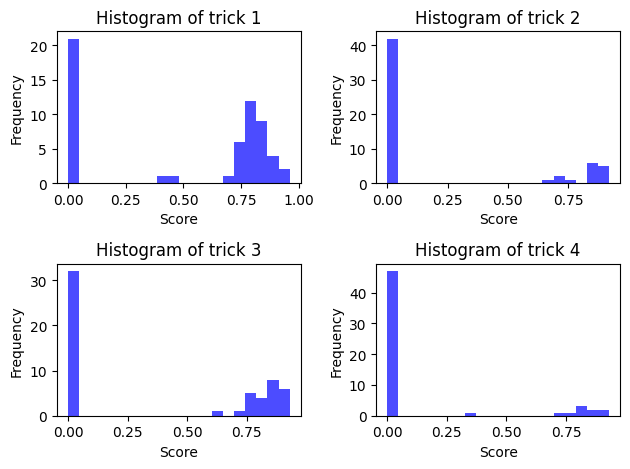

In [330]:
plot_histograms(df)

*From our observations, the most common score for each trick is zero, by a significant margin. The majority of other scores fall within the 0.6 to 0.9 range, with a noticeable lack of scores between 0 and 0.6. This pattern suggests that contestants tend to attempt more challenging tricks, which typically result in either failure (yielding a score of zero) or a relatively high score. This behavior indicates a tendency to bypass tricks of easy to medium difficulty.*

### (c)
- For each trick (1-4), create a new column named 'make i' for $i=1,2,3,4$. 
- The value of 'make i' in a given row should be 1 if the skateboarder successfully landed trick $i$ and 0 otherwise.

In [331]:
for i in range(1, 5):
    trick_column = f"trick {i}"
    
    # Assuming a trick is executed if its score > 0
    df.loc[:, f"make {i}"] = df.loc[:, trick_column].apply(lambda x: 1 if x > 0 else 0)

### (d)
For each skateboarder, estimate the probability that a trick receives a score greater than 0.6, given that the skateboarder successfully lands the trick. 
- What is the probability that the skateboarder fails to land a particular trick? 
- What observations can you make? Relate your findings to your observations in part (b).

In [332]:

def estimate_probabilities(df):

    grouped_df = df.groupby('id')
    results = []

    for name, group in grouped_df:

        successful_tricks = group[[f"trick {i}" for i in range(1, 6)]].applymap(lambda x: 1 if x > 0 else 0).sum().sum()
        
        # Probability that a trick receives a score greater than 0.6 given the trick was landed
        tricks_score_more_than_06 = group[[f"trick {i}" for i in range(1, 6)]].applymap(lambda x: 1 if x >= 0.6 else 0).sum().sum()

        # Probability that a trick receives a score greater than 0.6 given the trick was landed
        prob_success_given_landed = tricks_score_more_than_06 / successful_tricks if successful_tricks > 0 else 0
        
        # Probability that the skateboarder fails to land a trick
        total_tricks = group[[f"trick {i}" for i in range(1, 6)]].count().sum()
        failed_tricks = group[[f"trick {i}" for i in range(1, 6)]].applymap(lambda x: 1 if x == 0 else 0).sum().sum()
        prob_failure = failed_tricks / total_tricks
        
        results.append((name, prob_success_given_landed, prob_failure))
    
    # Uncoment to see the results
    #for name, success_given_landed, failure in results:
    #    print(f"Skateboarder {name}: P(Score > 0.6 | Landed) = {success_given_landed:.2f}, P(Failure) = {failure:.2f}")

In [333]:
#Please note that this is for all tricks!
estimate_probabilities(df)

**Here, I will add a modified version of this code that handles each trick separately!**

In [334]:
def estimate_probabilities_by_individual_trick(df):
    # Group by skateboarder's name to get each skateboarder's data across all locations
    grouped_df = df.groupby('id')

    results = []

    for name, group in grouped_df:
        for i in range(1, 6):  # Iterate through each trick
            trick_col = f"trick {i}"

            # Number of times this specific trick was landed by the skateboarder across all locations
            successful_tricks = group[trick_col].apply(lambda x: 1 if x > 0 else 0).sum()

            # Number of times this specific trick got a score >= 0.6 by the skateboarder across all locations
            tricks_score_more_than_06 = group[trick_col].apply(lambda x: 1 if x >= 0.6 else 0).sum()

            # Probability that this trick receives a score greater than 0.6 given the trick was landed
            prob_success_given_landed = tricks_score_more_than_06 / successful_tricks if successful_tricks > 0 else 0

            # Total attempts of this specific trick by the skateboarder across all locations
            total_tricks = group[trick_col].count()

            # Number of times this specific trick failed (scored 0) by the skateboarder across all locations
            failed_tricks = group[trick_col].apply(lambda x: 1 if x == 0 else 0).sum()

            # Probability that the skateboarder fails to land this trick
            prob_failure = failed_tricks / total_tricks if total_tricks > 0 else 0

            results.append((name, trick_col, prob_success_given_landed, prob_failure))
            
    # Uncomment to see the results
    # for name, trick, success_given_landed, failure in results:
    #     print(f"Skateboarder {name} for {trick}: P(Score > 0.6 | Landed) = {success_given_landed:.2f}, P(Failure) = {failure:.2f}")

In [335]:
estimate_probabilities_by_individual_trick(df)

### (e) 
Create a scatter plot for run score 1 versus run score 2. 

- Do you see any clear correlation from the diagram?

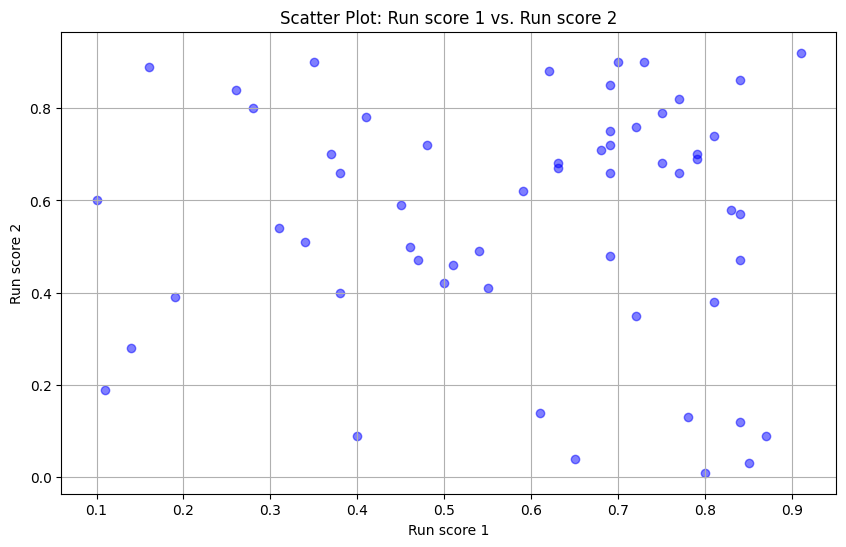

In [336]:
# Extracting data for plotting
x = df['run 1']
y = df['run 2']

# Creating the scatter plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='blue', alpha=0.5)
plt.title('Scatter Plot: Run score 1 vs. Run score 2')
plt.xlabel('Run score 1')
plt.ylabel('Run score 2')
plt.grid(True)

# Display the plot
plt.show()

# 2. A Frequentist Model

We'd like to construct a model that can predict which of the 16 skateboarders in the LCQ will secure a spot in the final. 

One approach to this is to construct a model for each skateboarder, utilize these models to simulate run scores and trick scores for every skateboarder, and then combine these simulations to simulate the LCQ as a whole. 

By simulating multiple LCQs, we can extract the top four skateboarders with the highest cumulative scores from each. 
Our prediction would then be the mode of these outcomes. 

**NOTE:** *Please note that this model assumes that the performances of the skateboarders are independent. For the sake of simplicity, we'll assume that the score for a particular run $Y_i$ and the score for a specific trick $X_i$ are independent for each skateboarder.*

- For skateboarder $i$, we assume that all trick scores and run scores are independent and have identically distributed outcomes from $X_i$ and $Y_i$ respectively. 

- We can start by specifying a model for $X_i$ and $Y_i$. 

---

From the observations in Task 1, a plausible model for $X_i$ is the following:
$$
X_i = 
\begin{cases} 
0 & \text{if } V_i = 0, \\ 
Z_i & \text{if } V_i = 1,
\end{cases}
$$
where 
$$ V_i \sim \text{Ber}(\theta_i), $$
$$ Z_i \sim \text{Beta}(\alpha_i, \beta_i) $$
and 
$$ V_i \perp Z_i. $$
It can be shown that
$$ 
f_{X_i}(x_i | \theta_i, \alpha_i, \beta_i) = (1-\theta_i) \mathbb{1}_{\{x_i=0\}} + \theta_i f_{Z_i}(z_i).
$$
The choice $ V_i \sim \text{Ber}(\theta_i) $ models the fact that a skateboarder receives a score of 0 if and only if they do not successfully land the trick. Meanwhile, the choice $ Z_i \sim \text{Beta}(\alpha_i, \beta_i) $ models that the score for a particular trick represents the portion of the trick that was "perfect."

## (a) Provide a point estimate for each $\theta_i$

### ANALYTICAL ANSWER:

https://en.wikipedia.org/wiki/Bernoulli_distribution

---



We can attempt a ML point estimation for $\theta_i$ since we know that $V_i$ follows a Bernoulli distribution with parameter $\theta_i$.

$$ V_i \sim \text{Ber}(\theta_i) $$
$$
f_{V_i}\left(\theta_i\right)=\theta_i^{v_i}\left(1-\theta_i\right)^{1-v_1}
$$

*Note: Parameter $\theta_i$ for $\text{Ber}(\theta_i)$ has to be $\theta_i \in[0,1]$ we lake this since we normalized the scores.*

$$
\log L\left(\theta \mid v_j\right)=\log \prod_i^n \theta_i^{v_i}(1-\theta_i)^{1-v_i}=
$$
$$
=\sum_{k=1}^n \log \theta_i^{v_k}(1-\theta_i)^{1-x_k}=\sum_{k=1}^n \log \theta_i^{v_k}+\sum_{k=1}^n \log \left(1-\theta_i\right)^{1-v_k}=
$$
$$
=\log \theta_i \cdot \sum_{k=1} V_k+\log \left(1-\theta_i\right) \sum\left(1-V_k\right)
$$

*We can now attmpt to take a derivative.*

$$
L^{\prime}\left(\theta_i \mid v\right)=\frac{\sum V_k}{\theta_i}-\frac{1}{1-\theta_i}\sum_{k=1}^n\left(1-v_k\right)=\frac{\sum_{k=1}^n v_k}{\theta_i}-\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}
$$

*To find the critical point we set $L^{\prime}\left(\theta_i \mid v\right)=0$*
$$
\frac{\sum_{k=1}^n v_k}{\theta_i}-\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}=0
$$

$$
\frac{\sum_{k=1}^n v_k}{\theta_i}-\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}=0
$$

$$
\frac{\sum_{k=1}^n v_k}{\theta_i}=\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}
$$

$$
\sum_{k=1}^n v_k-\theta_i \sum_{k=1}^n v_k=\theta_i n-\theta_i\sum_{k=1}^nv_k
$$

$$
\sum_{k=1}^n v_k=\theta_i n
$$

$$
\theta_i=\frac{\sum_{k=1}^n v_k}{n}
$$

***We can see that this is just a sample mean.***

---

### NUMERICAL ANSWER:

***Calculating $\theta_i$ for each  at each location:***

In [269]:
# Extracting data and calculating the mean for each skateboarder at each location.
make_columns = ['make 1', 'make 2', 'make 3', 'make 4']

df['total_made'] = df[make_columns].sum(axis=1)
df['total_attempted'] = df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].notna().sum(axis=1)
df['theta_i'] = df['total_made'] / df['total_attempted']

C:\Users\villi\AppData\Local\Temp\ipykernel_17140\2318382447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_made'] = df[make_columns].sum(axis=1)
C:\Users\villi\AppData\Local\Temp\ipykernel_17140\2318382447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_attempted'] = df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].notna().sum(axis=1)
C:\Users\villi\AppData\Local\Temp\ipykernel_17140\2318382447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

***Calculating colective $\theta_i$ for each skateboarder:***

In [270]:
# Group by 'id' and compute the mean of theta_i for each skateboarder
theta_average = df.groupby('id')['theta_i'].mean().reset_index()

# Rename the columns for clarity
theta_average.columns = ['id', 'theta_average']

#Okay, that's great! 
# Now I have this information, but I would like to save it into the main DataFrame file.
# Merge the theta_average DataFrame with the original df on 'id'
df = df.merge(theta_average, on='id', how='left')

# Uncoment to see the results.
#print(theta_average)


***Creating results_df***

In [271]:
# Round all float columns to 5 decimal places
df = df.round(5)
results_df = theta_average[['id', 'theta_average']]

results_df

,id,theta_average
0,Decenzo,0.437500
1,Eaton,0.625000
2,Foy,0.500000
3,Gustavo,0.400000
4,Hoban,0.400000
5,Hoefler,0.437500
6,Jordan,0.400000
7,Majerus,0.375000
8,Midler,0.333333
9,Mota,0.250000


## (b) Provide a point estimate for the parameters $\left[\alpha_i, \beta_i\right]^{\mathrm{T}}$ for each skateboarder $i$. 

### ANALYTICAL ANSWER:

https://en.wikipedia.org/wiki/Gamma_distribution

https://en.wikipedia.org/wiki/Beta_distribution

---

For the Beta distribution:
$$
f\left(z_i \mid \alpha_i, \beta_i\right)=\frac{z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}}{B\left(\alpha_i, \beta_i\right)}
$$
where $B\left(\alpha_i, \beta_i\right)$ is the beta function, which acts as a normalization constant.

From the provided data, we have scores for each trick when it's not zero. 
To estimate $\alpha_i$ and $\beta_i$, we can make use of the mean and variance properties of the Beta distribution.

To the population mean and variance, we knwo from formula sheet:

- Mean: $\mu=\frac{\alpha_i}{\alpha_i+\beta_i}$
- Variance: $\sigma^2=\frac{\alpha_i \beta_i}{\left(\alpha_i+\beta_i\right)^2\left(\alpha_i+\beta_i+1\right)}$

$$
\mu = \frac{\alpha}{\alpha+\beta} \quad \text { and } \quad S^2 = \frac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)} .
$$
Solving for $\alpha$ and $\beta$:
$$
\beta = \frac{\alpha - \alpha \mu}{\mu} = \frac{\alpha}{\mu} - \alpha .
$$
After substituting and simplifying, we find:
$$
\alpha = \mu\left(\frac{\mu(1-\mu)}{S^2}-1\right) .
$$
Expressing $\beta$ using $\mu$ and $S^2$:
$$
\beta = (1-\mu)\left(\frac{\mu(1-\mu)}{S^2}-1\right) .
$$
We can derive the method of moment estimators for $\alpha$ and $\beta$ are:
$$
\hat{\alpha} = \mu\left(\frac{\mu(1-\mu)}{S^2}-1\right) \text { and } \hat{\beta} = (1-\mu)\left(\frac{\mu(1-\mu)}{S^2}-1\right)
$$


---

We can write:
$$
f\left(x_i \mid \alpha, \beta, V_i=1\right) = f\left(z_i \mid \alpha, \beta\right) = L\left(\alpha, \beta \mid V_i=1, X_i=x_i\right)
$$

Lets rewrite the $\mathrm{B}(\alpha, \beta)$ function:


$$
\mathrm{B}(\alpha, \beta)=\frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha+\beta)}
$$

Now let's do the only thing we, God willing, know how to do: a ML point estimation.

$$
f_z(z \mid \alpha, \beta)=\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)} z^{\alpha-1}(1-z)^{\beta-1}
$$

$$
\log L(\alpha, \beta \mid z)=\log \prod_{i=1}^n\left(\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)} z_i^{\alpha-1}\left(1-z_i\right)^{\beta-1}\right)
$$

$$
=n \log \left(\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)}\right)+(\alpha-1) \sum_i^n \log z_i+(\beta-1) \sum_{i=1}^n \log \left(1-z_i\right)
$$

We take derivatives with respect to $\alpha$ and $\beta$.

For the first term, using the properties of logarithms and the derivative of the Gamma function, $\psi(z)=\frac{d}{d z} \log \Gamma(z)$, this we found online...

$$
\frac{\partial L}{\partial \alpha}=n \psi(\alpha+\beta)-n \psi(\alpha)+\sum_{i=1}^n \log z_i
$$

$$
\frac{\partial L}{\partial \beta}=n \psi(\alpha+\beta)-n \psi(\beta)+\sum_i^n \log \left(1-z_i\right)
$$

We can rewrite this as:

$$
\begin{aligned}
& \frac{\partial L}{\partial \alpha}=\psi(\alpha)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(z_i\right) \\
& \frac{\partial L}{\partial \beta}=\psi(\beta)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(1-z_i\right)
\end{aligned}
$$


*I guess this is the equivalent of running headfirst into a wall...*

---


### NUMERICAL ANSWER:

#### Getting the data

##### Obtaining all the tricks for a unique ID.

In [272]:
trick_columns = ['trick 1', 'trick 2', 'trick 3', 'trick 4']
# Group by 'id' and aggregate tricks for each skateboarder
all_tricks_df_with_zeroes = df.melt(id_vars='id', value_vars=trick_columns)\
                  .groupby('id')['value']\
                  .apply(list)\
                  .reset_index()
# Rename the columns for clarity
all_tricks_df_with_zeroes.columns = ['id', 'tricks']

# Uncoment this to see the results.
all_tricks_df_with_zeroes

,id,tricks
0,Decenzo,"[0.78, 0.86, 0.87, 0.0, 0.0, 0.0, 0.0, 0.86, 0..."
1,Eaton,"[0.75, 0.0, 0.84, 0.84, 0.77, 0.75, 0.0, 0.0]"
2,Foy,"[0.8, 0.0, 0.79, 0.83, 0.9, 0.0, 0.88, 0.9, 0...."
3,Gustavo,"[0.83, 0.0, 0.77, 0.8, 0.8, 0.74, 0.0, 0.0, 0...."
4,Hoban,"[0.0, 0.82, 0.91, 0.86, 0.86, 0.0, 0.92, 0.89,..."
5,Hoefler,"[0.0, 0.85, 0.73, 0.78, 0.67, 0.0, 0.0, 0.0, 0..."
6,Jordan,"[0.0, 0.0, 0.84, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,Majerus,"[0.79, 0.4, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0]"
8,Midler,"[0.0, 0.79, 0.0, 0.0, 0.0, 0.73, 0.87, 0.0, 0...."
9,Mota,"[0.78, 0.0, 0.69, 0.0, 0.87, 0.0, 0.0, 0.0, 0...."


##### Obtaining all the non-zero tricks for a unique ID.

In [273]:
# This function aggregates the tricks by filtering out zero values
def aggregate_tricks(tricks):
    return list(tricks[tricks != 0])

In [274]:
trick_columns = ['trick 1', 'trick 2', 'trick 3', 'trick 4']

# Group by 'id' and aggregate tricks for each skateboarder
all_tricks_df = df.melt(id_vars='id', value_vars=trick_columns)\
                  .groupby('id')['value']\
                  .agg(aggregate_tricks)\
                  .reset_index()

# Rename the columns for clarity
all_tricks_df.columns = ['id', 'tricks']

# Uncoment this to see the results.
all_tricks_df

,id,tricks
0,Decenzo,"[0.78, 0.86, 0.87, 0.86, 0.78, 0.93, 0.71]"
1,Eaton,"[0.75, 0.84, 0.84, 0.77, 0.75]"
2,Foy,"[0.8, 0.79, 0.83, 0.9, 0.88, 0.9]"
3,Gustavo,"[0.83, 0.77, 0.8, 0.8, 0.74, 0.83, 0.88, 0.76]"
4,Hoban,"[0.82, 0.91, 0.86, 0.86, 0.92, 0.89, 0.88, 0.88]"
5,Hoefler,"[0.85, 0.73, 0.78, 0.67, 0.78, 0.87, 0.75]"
6,Jordan,"[0.84, 0.9, 0.88, 0.9, 0.9, 0.7, 0.88, 0.91]"
7,Majerus,"[0.79, 0.4, 0.36]"
8,Midler,"[0.79, 0.73, 0.87, 0.84]"
9,Mota,"[0.78, 0.69, 0.87]"


#### Moment estimators

In [275]:
Moment_Estimators_results_alpha_beta_df = all_tricks_df.copy()

In [276]:
def get_moment_estimators(data):
    
    moment_estimators = []
    
    # I want to handel if I have only 1 datpoint.
    if len(data) == 1:
        mean = data[0]
        global_trick_data = sum(all_tricks_df['tricks'].tolist(), [])
        variance = np.var(global_trick_data, ddof=1)
    else:
        # Calculate mean
        mean = np.mean(data)
        
        # Calculate variance
        # ddof=1 means that we want to calculate the sample variance
        variance = np.var(data, ddof=1)
    
    #-----------------------------------
    
    # Calculate a1
    a1 = mean * (mean * (1 - mean) / variance - 1)
    moment_estimators.append(a1)
    
    # Calculate b1
    b1 = (1 - mean) * (mean * (1 - mean) / variance - 1)
    moment_estimators.append(b1)
    
    return moment_estimators


In [277]:
for index, row in Moment_Estimators_results_alpha_beta_df.iterrows():
    samps = np.array(row['tricks'])
    
    alpha_beta = get_moment_estimators(samps)
   
    Moment_Estimators_results_alpha_beta_df.at[index, 'alpha_trick'] = round(alpha_beta[0],2)
    Moment_Estimators_results_alpha_beta_df.at[index, 'beta_trick'] = round(alpha_beta[1],2)

In [278]:
results_df_Moment_Estimators = results_df.copy()

In [279]:
results_df_Moment_Estimators['alpha_trick'] = Moment_Estimators_results_alpha_beta_df['alpha_trick']
results_df_Moment_Estimators['beta_trick'] = Moment_Estimators_results_alpha_beta_df['beta_trick']
results_df_Moment_Estimators

,id,theta_average,alpha_trick,beta_trick
0,Decenzo,0.437500,20.84,4.36
1,Eaton,0.625000,60.17,15.99
2,Foy,0.500000,42.85,7.56
3,Gustavo,0.400000,61.71,15.31
4,Hoban,0.400000,94.13,13.14
5,Hoefler,0.437500,27.77,8.03
6,Jordan,0.400000,20.07,3.17
7,Majerus,0.375000,1.77,1.66
8,Midler,0.333333,32.59,7.77
9,Mota,0.250000,15.74,4.44



#### Gradient descent

##### Math and gameplan

*Let's do gradient descent and try to solve it numerically.*

Basic game plan:

1. ***Initialization:*** We choose initial values for $\alpha$ and $\beta$ at random or choose something sensible via prior knowledge.

2. ***Compute Gradient:*** At each iteration, we compute the gradient of the log-likelihood function with respect to $\alpha$ and $\beta$.
$$
\frac{\partial L}{\partial \alpha} \text { and } \frac{\partial L}{\partial \beta}
$$
3. ***Update Parameters:*** Update $\alpha$ and $\beta$ using the gradients:
Where $\eta$ is the learning rate. It's a hyperparameter that you'll need to set. A smaller value will make the optimization more stable but slower, while a larger value will speed up the optimization but can make it overshoot or even diverge.
$$
\begin{aligned}
& \alpha=\alpha+\eta \frac{\partial L}{\partial \alpha} \\
& \beta=\beta+\eta \frac{\partial L}{\partial \beta}
\end{aligned}
$$


4. ***Convergence Check***: Repeat steps 2 and 3 until we get change in the log-likelihood between iterations is below a predetermined threshold, or until a set number of iterations is reached.

5. ***Output***: Once convergence is achieved, the values of $\alpha$ and $\beta$ are your MLEs.

6.  ***Invoke the name of Olof***: This will remind you of how this is simmilar to what we did in SF1550.

***Initial guess use method of moments***

- Method of moments estimator we equate the population moments with the sample moments specifically the first and second moments.
- Then we solve for $\alpha$ and $\beta$ to get our moment estimators.


##### Code

In [280]:
Gradient_Descent_results_alpha_beta_df = all_tricks_df.copy()

In [281]:
def gradient(alpha_beta, data):
    alpha, beta = alpha_beta
    n = len(data)
    
    psi_alpha_plus_beta = sp.psi(alpha + beta)
    psi_alpha = sp.psi(alpha)
    psi_beta = sp.psi(beta)
    
    grad_alpha = psi_alpha - psi_alpha_plus_beta - (1/n)*np.sum(np.log(data))
    grad_beta = psi_beta - psi_alpha_plus_beta - (1/n)*np.sum(np.log(1 - data))
        
    return np.array([grad_alpha, grad_beta])

In [282]:
def graddes(initialization, stepsize, num_iter, data):
    thetas = [initialization]
    
    for _ in range(num_iter):
        thetas = thetas + [thetas[-1] - (stepsize)*gradient(thetas[-1], data)]
        
    return thetas

In [283]:
def gradient_method(samps):
    
    initialization = get_moment_estimators (samps)
    G = graddes(initialization, 0.003, 100, samps)

    return G

In [284]:
for index, row in Gradient_Descent_results_alpha_beta_df.iterrows():
    samps = np.array(row['tricks'])
    
    if len(samps) <= 1:
        alpha_beta = get_moment_estimators(samps)
    else:
        alpha_beta = gradient_method(samps)[-1]

            
    Gradient_Descent_results_alpha_beta_df.at[index, 'alpha_trick'] = round(alpha_beta[0],2)
    Gradient_Descent_results_alpha_beta_df.at[index, 'beta_trick'] = round(alpha_beta[1],2)

In [285]:
results_df_Gradient_Descent = results_df.copy()

In [286]:
results_df_Gradient_Descent['alpha_trick'] = Gradient_Descent_results_alpha_beta_df['alpha_trick']
results_df_Gradient_Descent['beta_trick'] = Gradient_Descent_results_alpha_beta_df['beta_trick']
results_df_Gradient_Descent

,id,theta_average,alpha_trick,beta_trick
0,Decenzo,0.437500,20.84,4.36
1,Eaton,0.625000,60.17,16.00
2,Foy,0.500000,42.85,7.56
3,Gustavo,0.400000,61.71,15.31
4,Hoban,0.400000,94.13,13.14
5,Hoefler,0.437500,27.77,8.03
6,Jordan,0.400000,20.07,3.18
7,Majerus,0.375000,1.80,1.68
8,Midler,0.333333,32.59,7.77
9,Mota,0.250000,15.75,4.45


####  Newton-Raphson or Gauss-Newton method.

##### Useful videos

<iframe width="560" height="315" src="https://www.youtube.com/embed/Iez_utKteSc?si=c5pHPINdqAsNKBZm" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/j16gn6Ehja0?si=kwQ6OojI94PGOLnG" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

##### Math and gameplan

$$
\begin{aligned}
& \frac{\partial L}{\partial \alpha}=\psi(\alpha)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(z_i\right) \\
& \frac{\partial L}{\partial \beta}=\psi(\beta)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(1-z_i\right)
\end{aligned}
$$


$$
J=\left|\begin{array}{ll}
\psi^{\prime}(\alpha)-\psi^{\prime}(\alpha+\beta) & -\psi^{\prime}(\alpha+\beta) \\
-\psi^{\prime}(\alpha+\beta)  & \psi^{\prime}(\beta)-\psi^{\prime}(\alpha+\beta)
\end{array}\right|
$$

$$
\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]_{\text{NM}}=\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]_N-J^{-1}\left(\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]_N\right)\left[\begin{array}{l}
f_1((\alpha, \beta)_N) \\
f_2((\alpha, \beta)_N)
\end{array}\right]
$$

We repeat this untile convergence.

##### Code

In [287]:
Newton_Raphson_results_alpha_beta_df = all_tricks_df.copy()

In [288]:
def Gauss_Raphson_method (data , tolerance=1e-6, max_iter=1000):
    
    alpha_beta = get_moment_estimators(data)
    alpha, beta = alpha_beta
    
    n = len(data)
    
    alpha_0, beta_0=alpha,beta

    theta = np.array([alpha_0, beta_0])
    
    for _ in range(max_iter):

        f = np.array([
            sp.psi(theta[0]) - sp.psi(np.sum(theta)) - np.mean(np.log(data)),
            sp.psi(theta[1]) - sp.psi(np.sum(theta)) - np.mean(np.log(1 - data))
        ])

        J = np.linalg.inv(np.array([
            [sp.polygamma(1, (theta[0])) - sp.polygamma(1, np.sum(theta)), -sp.polygamma(1, np.sum(theta))],
            [-sp.polygamma(1, np.sum(theta)), sp.polygamma(1, theta[1]) - sp.polygamma(1, np.sum(theta))]
        ]))

        # Newton-Raphson update
        J_inv = np.linalg.inv(J)
        theta = theta - J_inv @ f

        if np.linalg.norm(f) <= tolerance:
            return theta
    
    return theta
        

In [289]:
for index, row in Newton_Raphson_results_alpha_beta_df.iterrows():
    samps = np.array(row['tricks'])
    
    if len(samps) <= 1:
        alpha_beta = get_moment_estimators(samps)
    else:
         alpha_beta = Gauss_Raphson_method(samps)
    
    Newton_Raphson_results_alpha_beta_df.at[index, 'alpha_trick'] = round(alpha_beta[0],2)
    Newton_Raphson_results_alpha_beta_df.at[index, 'beta_trick'] = round(alpha_beta[1],2)

In [290]:
results_df_Newton_Raphson = results_df.copy()

In [291]:
results_df_Newton_Raphson['alpha_trick'] = Newton_Raphson_results_alpha_beta_df['alpha_trick']
results_df_Newton_Raphson['beta_trick'] = Newton_Raphson_results_alpha_beta_df['beta_trick']
results_df_Newton_Raphson

,id,theta_average,alpha_trick,beta_trick
0,Decenzo,0.437500,20.84,4.41
1,Eaton,0.625000,60.15,16.06
2,Foy,0.500000,42.84,7.64
3,Gustavo,0.400000,61.71,15.33
4,Hoban,0.400000,94.12,13.21
5,Hoefler,0.437500,27.75,8.08
6,Jordan,0.400000,20.06,3.36
7,Majerus,0.375000,3.01,2.73
8,Midler,0.333333,32.56,7.89
9,Mota,0.250000,15.73,4.58


##### Graphical representation

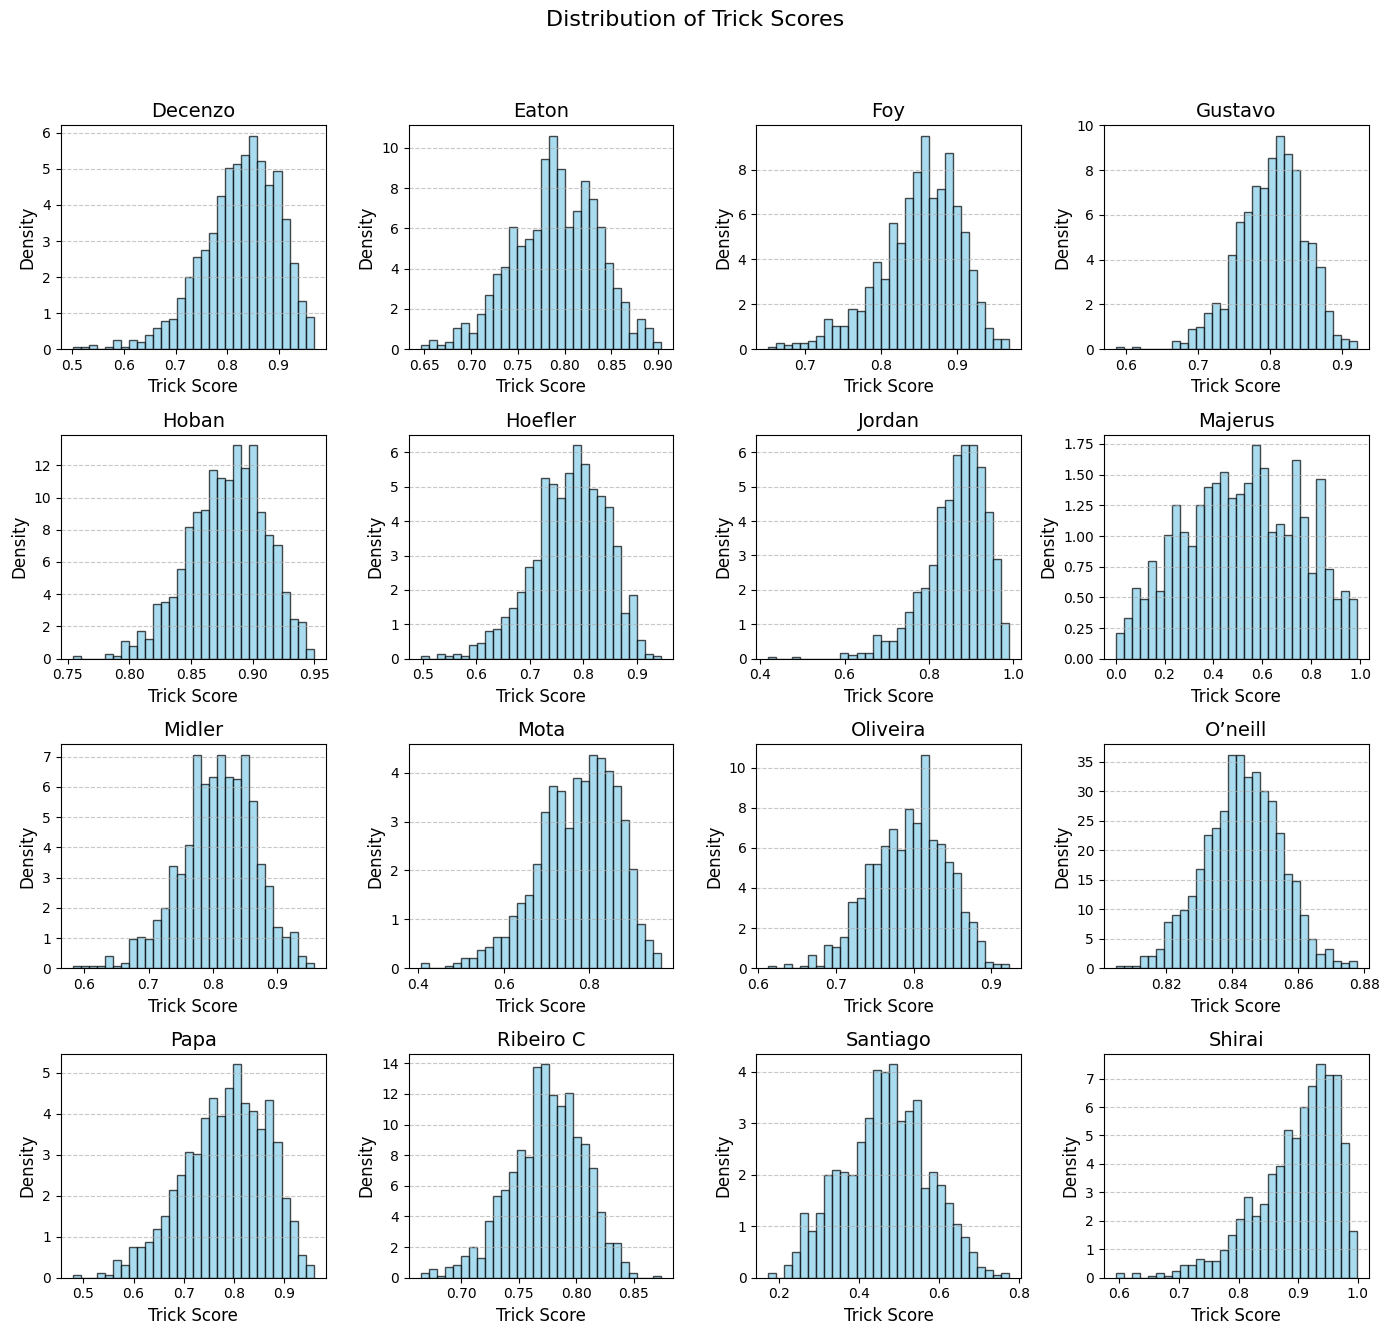

In [292]:
import matplotlib.pyplot as plt
import numpy as np

#----------------------------------
#Arsenal to choose from:
#----------------------------------
#results_df_Moment_Estimators
#results_df_Gradient_Descent
#results_df_Newton_Raphson
#----------------------------------

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

# Flatten the axes array to iterate over it
axes = axes.flatten()

for index, row in results_df_Moment_Estimators.iterrows():
    samps = np.random.beta(row['alpha_trick'], row['beta_trick'], size=1000)
    
    # Get the current subplot
    ax = axes[index]
    
    # Plot the histogram on the current subplot
    ax.hist(samps, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(row['id'], fontsize=14)
    ax.set_xlabel('Trick Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hide any remaining empty subplots
for i in range(len(results_df_Moment_Estimators), len(axes)):
    axes[i].axis('off')

fig.suptitle('Distribution of Trick Scores', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()


## (c) Propose a model for $Y_i$ and provide a point estimate for the parameters of your model. 

### ANALYTICAL ANSWER:

### NUMERICAL ANSWER:

#### Obtaining all the runs for a unique ID.

In [293]:
#Create all runs.
def aggregate_runs(runs):
    # This function aggregates the runs by filtering out zero values
    return list(runs[runs != 0])

# Assuming the runs are stored in columns named 'run1', 'run2', 'run3', etc.
run_columns = ['run 1', 'run 2']  # Add more columns if needed

# Group by 'id' and aggregate runs for each skateboarder
all_runs_df = df.melt(id_vars='id', value_vars=run_columns)\
                  .groupby('id')['value']\
                  .agg(aggregate_runs)\
                  .reset_index()

# Rename the columns for clarity
all_runs_df.columns = ['id', 'runs']

# Uncoment this to see the results.
all_runs_df

,id,runs
0,Decenzo,"[0.46, 0.83, 0.69, 0.31, 0.5, 0.58, 0.85, 0.54]"
1,Eaton,"[0.75, 0.69, 0.79, 0.72]"
2,Foy,"[0.54, 0.45, 0.1, 0.49, 0.59, 0.6]"
3,Gustavo,"[0.84, 0.16, 0.77, 0.59, 0.28, 0.12, 0.89, 0.8..."
4,Hoban,"[0.35, 0.75, 0.41, 0.51, 0.62, 0.9, 0.68, 0.78..."
5,Hoefler,"[0.79, 0.68, 0.85, 0.84, 0.69, 0.71, 0.03, 0.57]"
6,Jordan,"[0.73, 0.7, 0.84, 0.77, 0.26, 0.9, 0.9, 0.86, ..."
7,Majerus,"[0.4, 0.69, 0.09, 0.48]"
8,Midler,"[0.81, 0.8, 0.63, 0.74, 0.01, 0.68]"
9,Mota,"[0.38, 0.81, 0.34, 0.4, 0.38, 0.51]"


#### Using the Method of Moments:

In [294]:
Method_Moment_results_alpha_beta_df_runs = all_runs_df.copy()

In [295]:
for index, row in Method_Moment_results_alpha_beta_df_runs.iterrows():
    samps = np.array(row['runs'])
    
    alpha_beta = get_moment_estimators(samps)
    
    Method_Moment_results_alpha_beta_df_runs.at[index, 'alpha_run'] = round(alpha_beta[0],2)
    Method_Moment_results_alpha_beta_df_runs.at[index, 'beta_run'] = round(alpha_beta[1],2)

In [296]:
results_df_Moment_Estimators['alpha_run'] = Method_Moment_results_alpha_beta_df_runs['alpha_run']
results_df_Moment_Estimators['beta_run'] = Method_Moment_results_alpha_beta_df_runs['beta_run']
results_df_Moment_Estimators

,id,theta_average,alpha_trick,beta_trick,alpha_run,beta_run
0,Decenzo,0.437500,20.84,4.36,3.57,2.43
1,Eaton,0.625000,60.17,15.99,77.50,27.58
2,Foy,0.500000,42.85,7.56,2.85,3.32
3,Gustavo,0.400000,61.71,15.31,1.05,0.73
4,Hoban,0.400000,94.13,13.14,3.21,1.85
5,Hoefler,0.437500,27.77,8.03,1.45,0.80
6,Jordan,0.400000,20.07,3.17,3.17,1.08
7,Majerus,0.375000,1.77,1.66,1.21,1.71
8,Midler,0.333333,32.59,7.77,0.97,0.62
9,Mota,0.250000,15.74,4.44,3.30,3.72


#### Using the Gradient Descent:

In [297]:
Gradient_Descent_results_alpha_beta_df_runs = all_runs_df.copy()

In [298]:
for index, row in Gradient_Descent_results_alpha_beta_df_runs.iterrows():
    samps = np.array(row['runs'])
    
    alpha_beta = Gauss_Raphson_method(samps)
    
    Gradient_Descent_results_alpha_beta_df_runs.at[index, 'alpha_run'] = round(alpha_beta[0],2)
    Gradient_Descent_results_alpha_beta_df_runs.at[index, 'beta_run'] = round(alpha_beta[1],2)

In [299]:
results_df_Gradient_Descent['alpha_run'] = Gradient_Descent_results_alpha_beta_df_runs['alpha_run']
results_df_Gradient_Descent['beta_run'] = Gradient_Descent_results_alpha_beta_df_runs['beta_run']
results_df_Gradient_Descent

,id,theta_average,alpha_trick,beta_trick,alpha_run,beta_run
0,Decenzo,0.437500,20.84,4.36,3.91,2.66
1,Eaton,0.625000,60.17,16.00,77.48,27.64
2,Foy,0.500000,42.85,7.56,2.80,3.46
3,Gustavo,0.400000,61.71,15.31,1.57,1.18
4,Hoban,0.400000,94.13,13.14,3.63,2.09
5,Hoefler,0.437500,27.77,8.03,1.41,1.02
6,Jordan,0.400000,20.07,3.18,4.05,1.53
7,Majerus,0.375000,1.80,1.68,1.68,2.48
8,Midler,0.333333,32.59,7.77,28.00,22.08
9,Mota,0.250000,15.75,4.45,3.61,3.91


#### Using the Gauss-Raphson method:

In [300]:
Newton_Raphson_results_alpha_beta_df_runs = all_runs_df.copy()

In [301]:
for index, row in Newton_Raphson_results_alpha_beta_df_runs.iterrows():
    samps = np.array(row['runs'])
    
    alpha_beta = Gauss_Raphson_method(samps)
    
    Newton_Raphson_results_alpha_beta_df_runs.at[index, 'alpha_run'] = round(alpha_beta[0],2)
    Newton_Raphson_results_alpha_beta_df_runs.at[index, 'beta_run'] = round(alpha_beta[1],2)

In [302]:
results_df_Newton_Raphson['alpha_run'] = Newton_Raphson_results_alpha_beta_df_runs['alpha_run']
results_df_Newton_Raphson['beta_run'] = Newton_Raphson_results_alpha_beta_df_runs['beta_run']
results_df_Newton_Raphson

,id,theta_average,alpha_trick,beta_trick,alpha_run,beta_run
0,Decenzo,0.437500,20.84,4.41,3.91,2.66
1,Eaton,0.625000,60.15,16.06,77.48,27.64
2,Foy,0.500000,42.84,7.64,2.80,3.46
3,Gustavo,0.400000,61.71,15.33,1.57,1.18
4,Hoban,0.400000,94.12,13.21,3.63,2.09
5,Hoefler,0.437500,27.75,8.08,1.41,1.02
6,Jordan,0.400000,20.06,3.36,4.05,1.53
7,Majerus,0.375000,3.01,2.73,1.68,2.48
8,Midler,0.333333,32.56,7.89,28.00,22.08
9,Mota,0.250000,15.73,4.58,3.61,3.91


#### Graphical representation

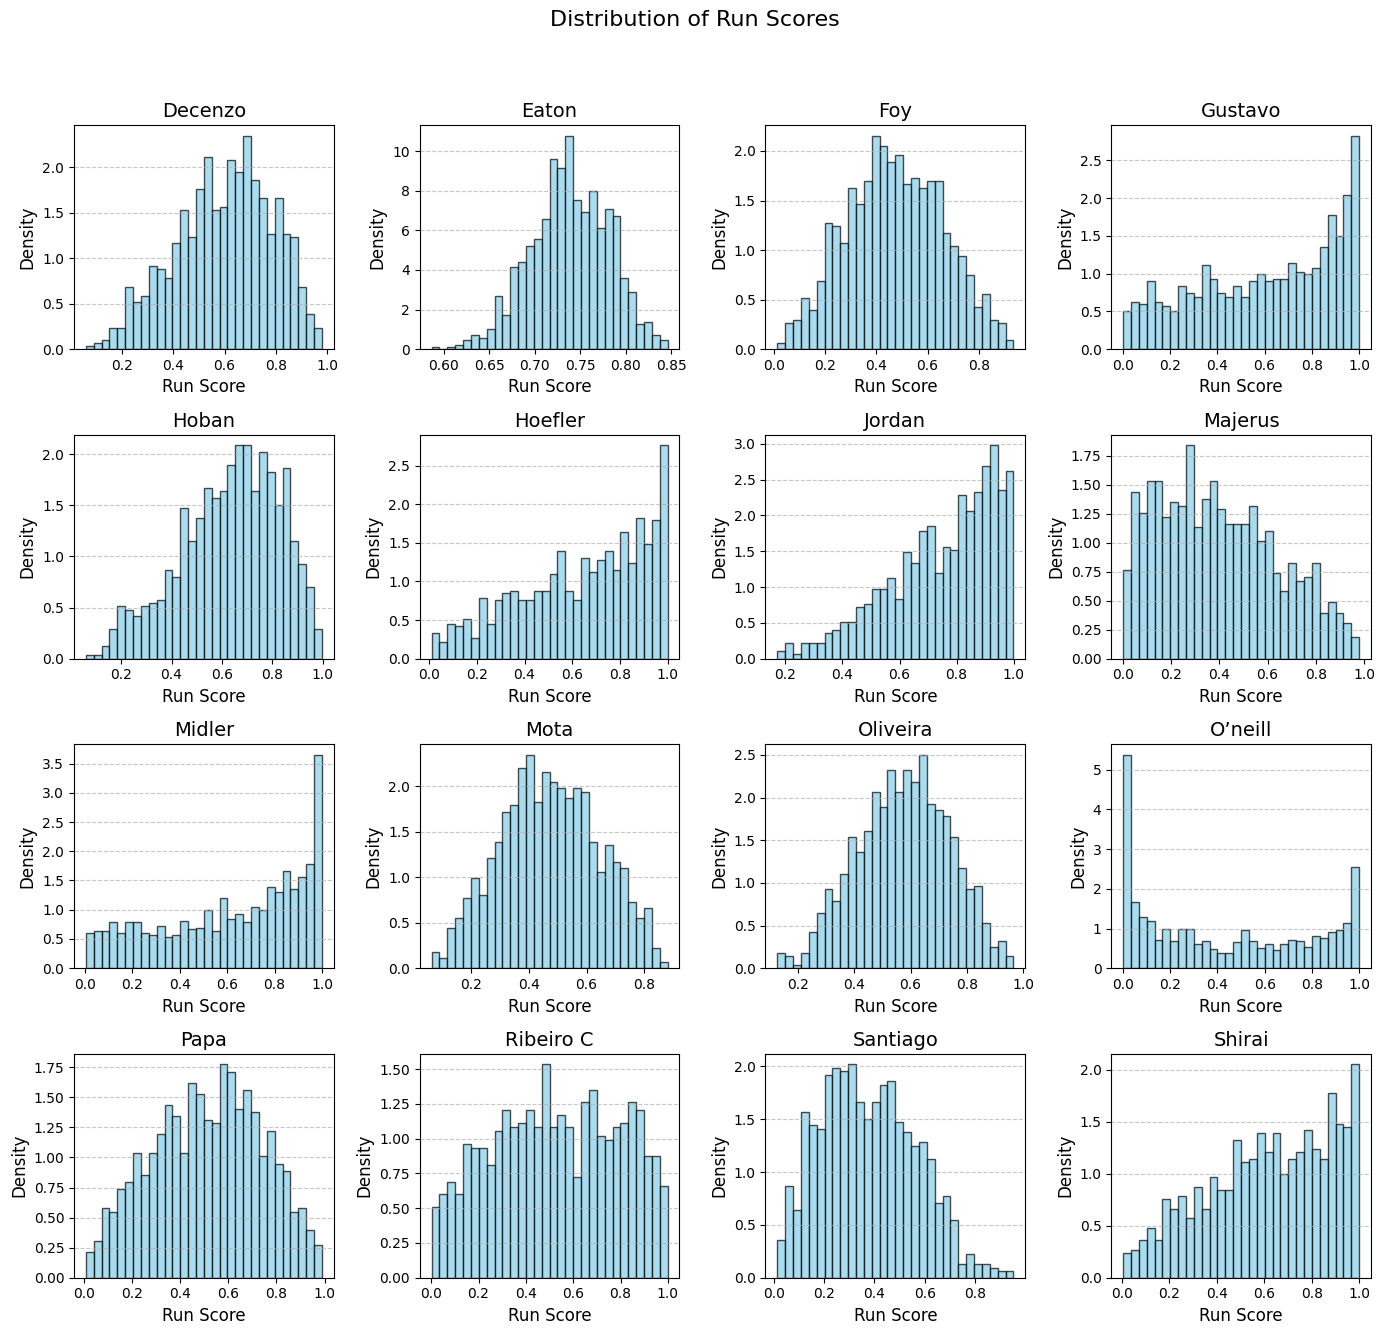

In [303]:
import matplotlib.pyplot as plt
import numpy as np

#----------------------------------
#Arsenal to choose from:
#----------------------------------
#results_df_Moment_Estimators
#results_df_Gradient_Descent
#results_df_Newton_Raphson
#----------------------------------


# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

# Flatten the axes array to iterate over it
axes = axes.flatten()

for index, row in results_df_Moment_Estimators.iterrows():
    samps = np.random.beta(row['alpha_run'], row['beta_run'], size=1000)
    
    # Get the current subplot
    ax = axes[index]
    
    # Plot the histogram on the current subplot
    ax.hist(samps, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(row['id'], fontsize=14)
    ax.set_xlabel('Run Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hide any remaining empty subplots
for i in range(len(results_df_Moment_Estimators), len(axes)):
    axes[i].axis('off')

fig.suptitle('Distribution of Run Scores', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## (d) Simulate LCQs

Use your model for $[X_i, Y_i]^T$ to simulate $5000$ LCQs and for each simulation extract the four skateboarders $\mathbf{W} = [W_1, W_2, W_3, W_4]^T$ with the highest total scores. 
- What is the mode for $W_1, \ldots, W_{5000}$? 

The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 

- How many of the actual winners are predicted by the mode? 
- What is the estimated probability of the actual winners based on your simulations? 
- By the mode?

### Simulation Code

#### All the small functions:

In [304]:
def successful_trick(theta):
    made=bool(np.random.binomial(1, theta))
    return made

In [305]:
def trick_score(alpha, beta):
    return stats.beta.rvs(alpha, beta, size=1)[0]

In [306]:
def run_score(alpha, beta):
    return stats.beta.rvs(alpha, beta, size=1)[0]

In [307]:
def total_score(trick_scores, run_scores):
    return max(run_scores) + sorted(trick_scores)[-1] + sorted(trick_scores)[-2]

In [308]:
def sort_my_df(new_lcq_df):
    sorted_df = new_lcq_df.sort_values(by='total score', ascending=False)
    return sorted_df

In [309]:
def simulate_lcq(chosen_results_df):
    new_lcq_df = pd.DataFrame(columns=["id", "run 1", "run 2", "trick 1", "trick 2", "trick 3", "trick 4"])
    
    for index, row in chosen_results_df.iterrows():
        
        theta_average=row['theta_average']
        alpha_trick=row['alpha_trick']
        beta_trick=row['beta_trick']    
        alpha_run=row['alpha_run']
        beta_run=row['beta_run']
        
        new_lcq_df.at[index, "id"]=row['id']
        
        for _ in range(4):
            if successful_trick(theta_average):
                trick=trick_score(alpha_trick, beta_trick)
            else:
                trick=0
            new_lcq_df.at[index, f"trick {_+1}"] = round(trick,1)
        
        for _ in range(2):
            run=run_score(alpha_run, beta_run)
            new_lcq_df.at[index, f"run {_+1}"] = round(run,1)
        
        total_score_value=total_score(new_lcq_df.loc[index, ['trick 1', 'trick 2', 'trick 3', 'trick 4']], new_lcq_df.loc[index, ['run 1', 'run 2']]) 
        new_lcq_df.at[index, "total score"]=round(total_score_value,1)
    
    return new_lcq_df

In [310]:
def find_top_four_skateboarders(new_lcq_df):
    return sort_my_df(new_lcq_df).head(4)

#### Simulation for mode:
- Look at Jordan and Shirai, figure out why?

In [311]:
# Moment Estimators #
#----------------------------------

top_four_rankings_Moment_Estimators = []  # Initialize the main list

for _ in range(5000):
    top_four_df = find_top_four_skateboarders(simulate_lcq(results_df_Moment_Estimators))
    
    # Extract IDs of the top four skateboarders and append them to the main list
    top_four_ids = top_four_df['id'].tolist()[:4]
    top_four_rankings_Moment_Estimators.append(top_four_ids)

In [312]:
# Transpose the list
transposed_rankings_Moment_Estimators = list(zip(*top_four_rankings_Moment_Estimators))
transposed_rankings = list(zip(*top_four_rankings_Moment_Estimators))
transposed_rankings = list(zip(*top_four_rankings_Moment_Estimators))

# Calculate mode for each position
modes_Moment_Estimators = [mode(rank) for rank in transposed_rankings_Moment_Estimators]

In [313]:
# Gradient Descent #
#----------------------------------

top_four_rankings_Gradient_Descent = []  # Initialize the main list

for _ in range(5000):
    top_four_df = find_top_four_skateboarders(simulate_lcq(results_df_Gradient_Descent))
    
    # Extract IDs of the top four skateboarders and append them to the main list
    top_four_ids = top_four_df['id'].tolist()[:4]
    top_four_rankings_Gradient_Descent.append(top_four_ids)

In [314]:
# Transpose the list
transposed_rankings_Gradient_Descent = list(zip(*top_four_rankings_Gradient_Descent))
transposed_rankings = list(zip(*top_four_rankings_Gradient_Descent))
transposed_rankings = list(zip(*top_four_rankings_Gradient_Descent))

# Calculate mode for each position
modes_Gradient_Descent = [mode(rank) for rank in transposed_rankings_Gradient_Descent]

In [315]:
# Newton Raphson #
#----------------------------------

top_four_rankings_Newton_Raphson = []  # Initialize the main list

for _ in range(5000):
    top_four_df = find_top_four_skateboarders(simulate_lcq(results_df_Newton_Raphson))
    
    # Extract IDs of the top four skateboarders and append them to the main list
    top_four_ids = top_four_df['id'].tolist()[:4]
    top_four_rankings_Newton_Raphson.append(top_four_ids)

In [316]:
# Transpose the list
transposed_rankings_Newton_Raphson = list(zip(*top_four_rankings_Newton_Raphson))
transposed_rankings = list(zip(*top_four_rankings_Newton_Raphson))
transposed_rankings = list(zip(*top_four_rankings_Newton_Raphson))

# Calculate mode for each position
modes_Newton_Raphson = [mode(rank) for rank in transposed_rankings_Newton_Raphson]

#### Using the dictionary to see the rankings:
- Look at Jordan and Shirai, figure out why?

In [317]:
#results_df_Moment_Estimators
#----------------------------------
point_counts_Moment_Estimators = {}

for _ in range(5000):
    top_four_df = find_top_four_skateboarders(simulate_lcq(results_df_Moment_Estimators))
    
    # Loop through the top 4 skateboarders and award them a point
    for i in range(4):
        skateboarder_id = top_four_df.iloc[i]['id']
        point_counts_Moment_Estimators[skateboarder_id] = point_counts_Moment_Estimators.get(skateboarder_id, 0) + 1

df_point_counts = pd.DataFrame(list(point_counts_Moment_Estimators.items()), columns=['id', 'points'])
df_ranked_Moment_Estimators = df_point_counts.sort_values(by='points', ascending=False)

In [318]:
#results_df_Gradient_Descent
#----------------------------------

point_counts_Gradient_Descent = {}

for _ in range(5000):
    top_four_df = find_top_four_skateboarders(simulate_lcq(results_df_Gradient_Descent))
    
    # Loop through the top 4 skateboarders and award them a point
    for i in range(4):
        skateboarder_id = top_four_df.iloc[i]['id']
        point_counts_Gradient_Descent[skateboarder_id] = point_counts_Gradient_Descent.get(skateboarder_id, 0) + 1

df_point_counts = pd.DataFrame(list(point_counts_Gradient_Descent.items()), columns=['id', 'points'])
df_ranked_Gradient_Descent = df_point_counts.sort_values(by='points', ascending=False)

In [319]:
#results_df_Newton_Raphson
#----------------------------------

point_counts_Newton_Raphson = {}

for _ in range(5000):
    top_four_df = find_top_four_skateboarders(simulate_lcq(results_df_Newton_Raphson))
    
    # Loop through the top 4 skateboarders and award them a point
    for i in range(4):
        skateboarder_id = top_four_df.iloc[i]['id']
        point_counts_Newton_Raphson[skateboarder_id] = point_counts_Newton_Raphson.get(skateboarder_id, 0) + 1

df_point_counts = pd.DataFrame(list(point_counts_Newton_Raphson.items()), columns=['id', 'points'])
df_ranked_Newton_Raphson = df_point_counts.sort_values(by='points', ascending=False)

#### RESULTS:


---

***Using Mode for all 3 results dataframes:***

In [320]:
print("For Moment Estimators:", modes_Moment_Estimators)
print("For Gradient Descent:", modes_Gradient_Descent)
print("For Newton Raphson:", modes_Newton_Raphson)

For Moment Estimators: ['Jordan', 'Hoban', 'Eaton', 'Eaton']
For Gradient Descent: ['Jordan', 'Eaton', 'Eaton', 'Eaton']
For Newton Raphson: ['Jordan', 'Eaton', 'Eaton', 'Eaton']


The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 


---

***Using Moment Estimators***

In [321]:
df_ranked_Moment_Estimators['rank'] = df_ranked_Moment_Estimators['points'].rank(ascending=False)
df_ranked_Moment_Estimators

,id,points,rank
7,Eaton,2708,1.0
6,Jordan,2355,2.0
1,Hoban,2152,3.0
0,Shirai,2047,4.0
5,Decenzo,1935,5.0
3,Hoefler,1704,6.0
4,Gustavo,1536,7.0
2,Foy,1468,8.0
10,Midler,1238,9.0
13,Papa,808,10.0


The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 


---

***Using Gradient Descent***

In [322]:
df_ranked_Gradient_Descent['rank'] = df_ranked_Gradient_Descent['points'].rank(ascending=False)
df_ranked_Gradient_Descent

,id,points,rank
3,Eaton,3150,1.0
1,Jordan,2420,2.0
7,Hoban,2290,3.0
9,Decenzo,2091,4.0
2,Shirai,2060,5.0
8,Foy,1579,6.0
5,Hoefler,1535,7.0
0,Gustavo,1496,8.0
13,Oliveira,927,9.0
4,Papa,792,10.0


The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 


---

***Using Newton Raphson***

In [323]:
df_ranked_Newton_Raphson['rank'] = df_ranked_Newton_Raphson['points'].rank(ascending=False)
df_ranked_Newton_Raphson

,id,points,rank
7,Eaton,3143,1.0
9,Jordan,2344,2.0
0,Hoban,2251,3.0
5,Shirai,2059,4.0
4,Decenzo,2056,5.0
6,Foy,1627,6.0
11,Hoefler,1544,7.0
2,Gustavo,1518,8.0
3,Oliveira,899,9.0
8,Papa,825,10.0


The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 

# 3. Bayesian Model

As an alternative to the frequentist model developed in Task 2, we can consider a Bayesian model.
$$
\Theta_i \perp A_i, B_i
$$
$$
f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right)=f_{\Theta_i}\left(\theta_i\right) f_{A_i, B_i}\left(\alpha_i, \beta_i\right)
$$

#### Useful videos

<iframe width="560" height="315" src="https://www.youtube.com/embed/0F0QoMCSKJ4?si=w7JY36TpygsHr_r2" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/OTO1DygELpY?si=o--yk03nV36-5p7o" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/0lpT-yveuIA?si=i_yIc54L-IBub6tV" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In [324]:
#Get Data
initial_bayesian_df_tricks = all_tricks_df_with_zeroes.copy()[all_tricks_df_with_zeroes['id'].isin(contestants)]

initial_bayesian_df_tricks['theta_average'] = round(results_df_Moment_Estimators['theta_average'],4)
initial_bayesian_df_tricks['alpha_trick'] = results_df_Moment_Estimators['alpha_trick']
initial_bayesian_df_tricks['beta_trick'] = results_df_Moment_Estimators['beta_trick']

# Uncoment this to see the results.
initial_bayesian_df_tricks

,id,tricks,theta_average,alpha_trick,beta_trick
0,Decenzo,"[0.78, 0.86, 0.87, 0.0, 0.0, 0.0, 0.0, 0.86, 0...",0.4375,20.84,4.36
1,Eaton,"[0.75, 0.0, 0.84, 0.84, 0.77, 0.75, 0.0, 0.0]",0.6250,60.17,15.99
2,Foy,"[0.8, 0.0, 0.79, 0.83, 0.9, 0.0, 0.88, 0.9, 0....",0.5000,42.85,7.56
3,Gustavo,"[0.83, 0.0, 0.77, 0.8, 0.8, 0.74, 0.0, 0.0, 0....",0.4000,61.71,15.31
4,Hoban,"[0.0, 0.82, 0.91, 0.86, 0.86, 0.0, 0.92, 0.89,...",0.4000,94.13,13.14
5,Hoefler,"[0.0, 0.85, 0.73, 0.78, 0.67, 0.0, 0.0, 0.0, 0...",0.4375,27.77,8.03
6,Jordan,"[0.0, 0.0, 0.84, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.4000,20.07,3.17
7,Majerus,"[0.79, 0.4, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0]",0.3750,1.77,1.66
8,Midler,"[0.0, 0.79, 0.0, 0.0, 0.0, 0.73, 0.87, 0.0, 0....",0.3333,32.59,7.77
9,Mota,"[0.78, 0.0, 0.69, 0.0, 0.87, 0.0, 0.0, 0.0, 0....",0.2500,15.74,4.44


## (a) Propose a joint prior distribution for the parameters $[\Theta_i, A_i, B_i]^T$ for $X_i$ where we assume $\Theta_i \perp A_i, B_i$ for all $i$. 

### Prior for $\Theta_i$:

   
- $\Theta_i$ represents the average value of a skateboarder landing a trick. 
- Since $\Theta_i$ is an average value, it will lie between 0 and 1. 
- A natural choice for a prior distribution for a parameter that lies between 0 and 1 is the Beta distribution since it is defined on the interval [0,1]. 

If we use a non-informative prior, no strong beliefs about the distribution of $\Theta_i$ before observing the data. 
A common choice, according to the notes, would be $Beta(1,1)$, which is equivalent to a uniform distribution on [0,1].

$$
f_{\Theta_i}\left(\theta_i\right)=\operatorname{Beta}\left(\theta_i ; 1,1\right)=U(0,1)
$$


### Prior for  $A_i$, $B_i$:

- Since $A_i$, $B_i$ are are parameters for a distribution that produces results between 0 and 1, a natural choice for their prior distribution is the Beta distribution.

## (b) Generate 5000 random samples from the posterior distribution
$$
f_{\Theta_i, \alpha_i, \beta_i | \boldsymbol{X}_i}(\theta_i, \alpha_i, \beta_i | \boldsymbol{x}_i) .
$$
Plot your resulting samples for the marginal posterior distributions:
$$
f_{\theta_i | \boldsymbol{X}_i}(\theta_i | \boldsymbol{x}_i) \quad \text{and} \quad f_{\alpha_i, \beta_i | \boldsymbol{X}_i}(\alpha_i, \beta_i | \boldsymbol{x}_i) .
$$

- Calculate the posterior sample mean and the posterior sample variance for each parameter $ \theta_i, \alpha_i $, and $ \beta_i $ for all skateboarders.


---

We know:
$$
X_i \mid \Theta_i=\theta_i, A_i=\alpha_i, B_i=\beta_i
$$


- $ \Theta_i$ represents the average value of a skateboarder landing a trick.
- $ A_i$ and $ B_i$ are parameters for a distribution.

We are interested in the behavior or distribution of $ X_i$, the observed data for skateboarder $ i$, when the parameters $\Theta_i$, $ A_i$, and $ B_i$ are fixed at specific values.

Given the above, the joint prior distribution for $\theta_i, A_i$, and $B_i$ is:
$$
f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right)=f_{\Theta_i}\left(\theta_i\right)  f_{A_i, B_i}\left(\alpha_i, \beta_i\right)
$$

Given the likelihood $f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)$, the posterior distribution is:
$$
f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)
$$
$$
f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i}\left(\theta_i\right)  f_{A_i, B_i}\left(\alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)
$$
We can use Metropolis Algorithm on this part: 

$$
f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(\mathbb{x} \mid \theta_i, \alpha_i, \beta_i\right)
$$

### ANALYTICAL ANSWER:

#### First try (wrong)

$$
f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i}\left(\theta_i\right) f_{A_i, B_i}\left(\alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)
$$

$$
f_{\Theta_i, A_i, B_i}(\theta_i, \alpha_i, \beta_i)=\left(\frac{1}{\bar{B}\left(\alpha_\theta, \beta_\theta\right)} \theta^{\alpha_\theta-1}(1-\theta)^{\beta_\theta-1}\right) \times(\alpha_i+\beta_i)^{-5 / 2}
$$

The likelihood is composed of two indicator functions $\mathbf{1}_{\boldsymbol{x}=\mathbf{0}}$ and $\mathbf{1}_{\boldsymbol{x}=\mathbf{1}}$, so we are going to have two posterior distributions: One where $x=0$ and one for $x>0$. 

- For $x>0$ we get: 

$$
f_{\Theta, A, B  \mid \boldsymbol{X}}(\theta, \alpha, \beta  \mid \boldsymbol{x})=\left(\frac{1}{B\left(\alpha_\theta, \beta_\theta\right)} \theta^{\alpha_\theta-1}(1-\theta)^{\beta_\theta-1}\right) (\alpha+\beta)^{-5 / 2} \left(\prod_{i=1}^n \theta  \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}\right)
$$

- The parameters $\alpha_\theta$ and $\beta_\theta$ are the hyperparameters of the Beta distribution for $\theta$, since I assume that $\theta$ is Beta($\theta_i$, 1, 1)=$U(0,1)$, this would mean $\alpha_\theta=1$ and $\beta_\theta=1$.
- In this part $(\alpha+\beta)^{-5 / 2}$, my initial guess for $\alpha$ and $\beta$ is by moment method for the whole population.
- In this part $\left(\prod_{i=1}^n \theta \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}\right)$, we use data from Part II.

For $\theta \sim \operatorname{Beta}(1,1)$, the log PDF is:
$$
\log f_{\Theta_i}\left(\theta_i\right)=\log \left(\frac{\Gamma(1+1)}{\Gamma(1) \Gamma(1)} \theta_i^{1-1}\left(1-\theta_i\right)^{1-1}\right)
$$
Since $\Gamma(1)=1$, the log PDF simplifies to:
$$
\log f_{\Theta_i}\left(\theta_i\right)=\log \left(\theta_i\right)+\log \left(1-\theta_i\right)
$$

$$(\alpha+\beta)^{-5 / 2}$$
$$
-\frac{5}{2} \log (\alpha+\beta)
$$

$$
\log \left(\theta_i\right)+\log \left(1-\theta_i\right) -\frac{5}{2} \log (\alpha+\beta)
$$

$$
\prod_{i=1}^n \theta \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}
$$
$$
\sum_{i=1}^n \log \left(\theta \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}\right)
$$
$$
\sum_{i=1}^n\left(\log (\theta)+\log \left(\frac{1}{B\left(\alpha_i, \beta_i\right)}\right)+\log \left(z_i^{\alpha_i-1}\right)+\log \left(\left(1-z_i\right)^{\beta_i-1}\right)\right)
$$
$$
\sum_{i=1}^n \log (\theta)+\sum_{i=1}^n \log \left(\frac{1}{B\left(\alpha_i, \beta_i\right)}\right)+\sum_{i=1}^n \log \left(z_i^{\alpha_i-1}\right)+\sum_{i=1}^n \log \left(\left(1-z_i\right)^{\beta_i-1}\right)
$$
$$
n \log (\theta)+\left(\sum_{i=1}^n \log \left(\frac{1}{B\left(\alpha_i, \beta_i\right)}\right)\right)+\left(\sum_{i=1}^n\left(\alpha_i-1\right) \log \left(z_i\right)\right) +\left(\sum_{i=1}^n\left(\beta_i-1\right) \log \left(1-z_i\right)\right)
$$

- Since  $\theta_i$, $\alpha_i$ and $\beta_i$ are the same for each contestant and only $z_i$ changes we can write: 
$$
n \log (\theta)+\left(\sum_{i=1}^n \log \left(\frac{1}{B\left(\alpha, \beta\right)}\right)\right)+\left(\sum_{i=1}^n\left(\alpha-1\right) \log \left(z_i\right)\right)+\left(\sum_{i=1}^n\left(\beta-1\right) \log \left(1-z_i\right)\right)
$$

#### Second try

##### Apriori $f_{\Theta_i}(\theta_i)$

- Assuming that the trick was landed, we can simply use $f_{\Theta_i}(\theta_i) = 1$.
- This will greatly simplify our equation!

##### Apriori $f_{A, B}(\alpha, \beta)$

We can use reparametrization for $f_{A, B}(\alpha, \beta)$:

$$
\mu=\frac{\alpha}{\alpha+\beta} \quad \text { och } \quad \kappa=\alpha+\beta+1
$$
To see that $\kappa$ is a measure of precision, note that for $X \sim \operatorname{Beta}(\alpha, \beta)$,

$$
\operatorname{Var}[X]=\frac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}=\frac{\mu(1-\mu)}{\kappa} ;
$$

i.e., $\kappa$ is inversely proportional to $\operatorname{Var}[X]$.
- We can then specify a prior distribution for $[\mu, \kappa]^{\mathrm{T}}$ and take a transformation of stochastic variables to obtain a prior distribution for $[\alpha, \beta]^{\mathrm{T}}$. 
- We form a conditional prior distribution for $[\mu, \kappa]^{\mathrm{T}}$ according to the factorization

$$
(\mu, \kappa)=(\kappa \mid \mu) f(\mu)
$$

where we take

$$
\begin{aligned}
\kappa \mid \mu & \sim \operatorname{Gamma}(\theta, \lambda), \\
\mu & \sim \mathrm{U}(0,1) .
\end{aligned}
$$

This gives us the distribution

$$
f_{A, B}(\alpha, \beta)=\frac{\lambda^\theta}{\Gamma(\theta)}(\alpha+\beta+1)^{\theta-1} e^{-\lambda(\alpha+\beta+1)}(\alpha+\beta)^{-1}
$$


##### Data distirbution $f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)$

We know from the problem statement that:
$$
f_{X_i}\left(x_i \mid \theta_i, \alpha_i, \beta_i\right)=\left(1-\theta_i\right) \mathbf{1}_{x_i=0}+\theta_i f_{Z_i}\left(z_i\right)
$$
We substitute in the $Beta(\alpha_i, \beta_i)$:
$$
f_{X_i}\left(x_i \mid \theta_i, \alpha_i, \beta_i\right)=\left(1-\theta_i\right) \mathbf{1}_{x_i=0}+\theta_i \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)+\Gamma(\beta)} z_i^{\alpha-1}(1-z)^{\beta-1}\mathbf{1}_{x_i \neq 0}
$$

##### Thus, if we combine everything $f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i}\left(\theta_i\right)  f_{A_i, B_i}\left(\alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)$:

$$
1\times \left(\frac{\lambda^{\theta_{hyper}}_{hyper}}{\Gamma(\theta_{hyper})}(\alpha+\beta+1)^{\theta_{hyper}-1} e^{-\lambda_{hyper}(\alpha+\beta+1)}(\alpha+\beta)^{-1}\right)\times\left( \left(1-\theta_i\right) \mathbf{1}_{x_i=0}+\theta_i \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)+\Gamma(\beta)} z_i^{\alpha-1}(1-z)^{\beta-1}\mathbf{1}_{x_i \neq 0}\right)
$$

- This appears quite complex to implement, so let's log everything.

##### Log-ing everything:

$\log f_{A_j B_j }\left(\alpha_j, \beta_j \right)=$
$$
\theta_{hyper} \log (\lambda_{hyper})-\log (\Gamma(\theta_{hyper}))+(\theta_{hyper}-1) \log (\alpha+\beta+1)-\lambda_{hyper}(\alpha+\beta+1)-\log (\alpha+\beta)
$$
$\log f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)=$
$$
\log(1-\theta) \cdot \mathbb{1}_{\{x_i=0\}} + \left(\log(\theta_i) + \log(\Gamma(\alpha+\beta)) - \log(\Gamma(\alpha)+\Gamma(\beta)) + (\alpha-1) \log(z_i) + (\beta-1) \log(1-z_i)\right)\mathbf{1}_{x_i \neq 0}.
$$

### CODE:

##### Initial guesses via Moment Estimators:
- Initial parameter guess for the prior distributions can be obtained using the moment method for the entire population.

In [325]:
#Note: merged_tricks is a list of all tricks including 0s
merged_tricks_with_zeroes = [item for sublist in initial_bayesian_df_tricks['tricks'] for item in sublist]

#Note: merged_tricks_without_zeroes is a list of all tricks without 0s
merged_tricks_without_zeroes=[x for x in merged_tricks_with_zeroes if x != 0]

initial_guess_trick_with_zeroes=round(get_moment_estimators(merged_tricks_with_zeroes),5)
inital_guess_tricks_without_zeroes=round(get_moment_estimators(merged_tricks_without_zeroes),5)

print("Without Zeroes the intial guess for Alpha and Beta via moment estimators would be:", inital_guess_tricks_without_zeroes)
print("With Zeroes the intial guess for Alpha and Beta via moment estimators would be:", initial_guess_trick_with_zeroes)

TypeError: type list doesn't define __round__ method

##### Defining priors and posteriors

***This is the first log_prior I used. Now I belive it is wrong***

In [ ]:
#def log_prior(alpha, beta, precision, lambda_hyper):
#    theta_hyper = lambda_hyper * precision
#    return theta_hyper * np.log(lambda_hyper) - gammaln(theta_hyper) + (theta_hyper - 1) * np.log(alpha + beta + 1) - lambda_hyper * (alpha + beta + 1) - np.log(alpha + beta)

***This log_prior seems to be working great!***

In [ ]:
def log_prior(alpha, beta, precision, lambda_hyper):
    theta_hyper = lambda_hyper*precision
    return   theta_hyper * np.log(lambda_hyper) - loggamma(theta_hyper) + (theta_hyper - 1) * np.log(alpha + beta + 1) - lambda_hyper * (alpha + beta + 1) - np.log(alpha + beta)


---

***This is my log_posterior.***

In [ ]:
def log_posterior(alpha, beta, theta, data):
    precision = 5
    lambda_hyper = 0.5

    log_p = log_prior(alpha, beta, precision, lambda_hyper)

    for z_i in data:
        
        if z_i == 0:
            log_p += np.log(1 - theta)
        else:
            log_p += np.log(theta) + loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(z_i) + (beta-1) * np.log(1 - z_i)
            
    return log_p

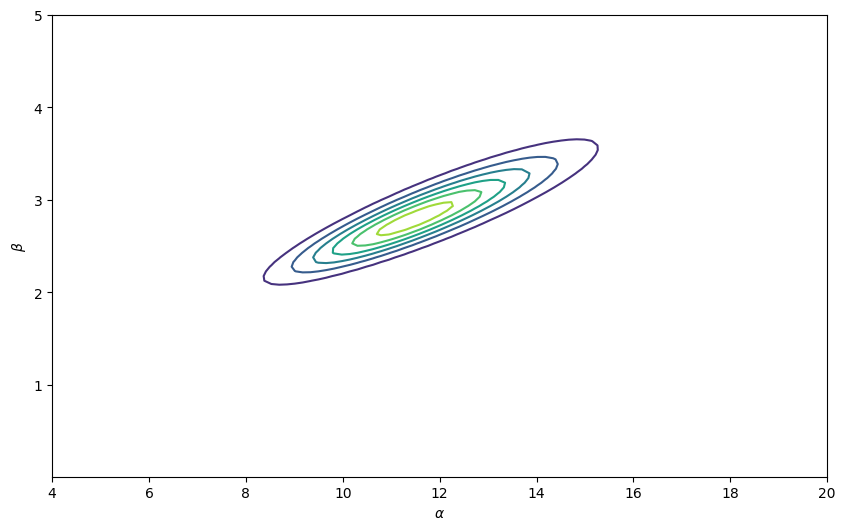

In [ ]:
data=merged_tricks_with_zeroes
alpha_grid = np.linspace(4, 20, 100)
beta_grid = np.linspace(0.01, 5, 100)
theta=0.5

log_posterior_grid = [[log_posterior(alpha, beta, theta, data) for alpha in alpha_grid] for beta in beta_grid]

# För att undvika underflow när vi exponentierar log-täthetsfunktionen subtraherar vi först det största värdet,
# vilket gör att det största värdet efter exponentiering alltid är ett.
posterior_grid = np.exp(log_posterior_grid - np.max(log_posterior_grid))

plt.figure(figsize=(10, 6))
plt.contour(alpha_grid, beta_grid, posterior_grid)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.show()

##### First try at Metropolis algorithm:

In [ ]:
def metropolis_algorithm_alt1(data, num_samples=10000):
    # Initial Candidates
    theta = 0.5
    alpha = inital_guess_tricks_without_zeroes[0]
    beta = inital_guess_tricks_without_zeroes[1]

    params = []

    for _ in range(num_samples):
        # Propose new candidates
        theta_new = np.random.uniform(0, 1)
        alpha_new = abs(np.random.normal(alpha, 0.5))
        beta_new = abs(np.random.normal(beta, 0.5))

        # Calculate acceptance ratio
        log_ratio = (log_posterior(alpha_new, beta_new, theta_new, data) - 
                     log_posterior(alpha, beta, theta, data))

        # Acceptance criterion
        if np.log(np.random.uniform(0, 1)) < log_ratio:
            theta = theta_new
            alpha = alpha_new
            beta = beta_new

        params.append((theta, alpha, beta))

    return params

In [ ]:
initial_bayesian_df_tricks = initial_bayesian_df_tricks.assign(params=None)

for index, row in initial_bayesian_df_tricks.iterrows():
    
    data = np.array(row['tricks'])
    params=metropolis_algorithm_alt1(data)
    
    initial_bayesian_df_tricks.at[index, 'params'] = params
    
initial_bayesian_df_tricks['theta_metropolis'] = initial_bayesian_df_tricks['params'].apply(lambda x: x[-1][0])
initial_bayesian_df_tricks['alpha_metropolis'] = initial_bayesian_df_tricks['params'].apply(lambda x: x[-1][1])
initial_bayesian_df_tricks['betha_metropolis'] = initial_bayesian_df_tricks['params'].apply(lambda x: x[-1][2])

initial_bayesian_df_tricks[['id','theta_average', 'theta_metropolis', 'alpha_metropolis', 'betha_metropolis']]

           id  theta_average  theta_metropolis  alpha_metropolis  \
0     Decenzo       0.437500          0.472681          2.842419   
1       Eaton       0.625000          0.530894          9.833541   
2         Foy       0.500000          0.555641          7.887081   
3     Gustavo       0.400000          0.265056          4.351806   
4       Hoban       0.400000          0.642717         10.188761   
5     Hoefler       0.437500          0.495689          5.661669   
6      Jordan       0.400000          0.401729          5.996878   
7     Majerus       0.375000          0.339083          4.861148   
8      Midler       0.333333          0.348886          3.980798   
9        Mota       0.250000          0.174729          1.808143   
10   Oliveira       0.416667          0.608090          3.677148   
11    O’neill       0.250000          0.247316          2.783012   
12       Papa       0.437500          0.428973          5.727772   
13  Ribeiro C       0.250000          0.223420  

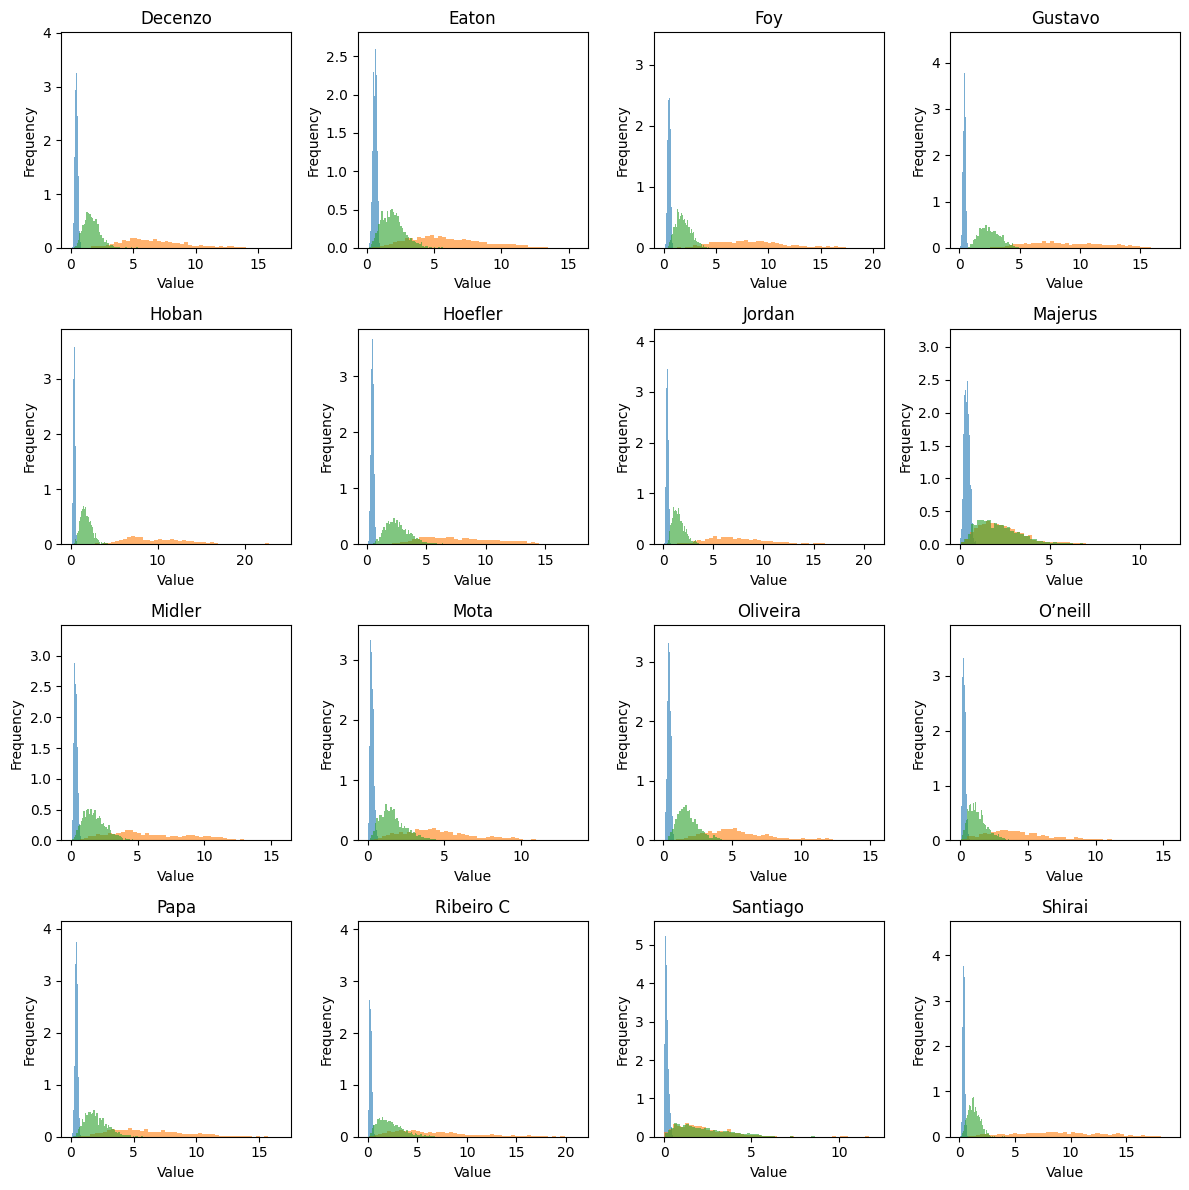

In [ ]:
import matplotlib.pyplot as plt


# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for index, row in initial_bayesian_df_tricks.iterrows():
    params_data = row['params']
    
    # Get the current subplot
    ax = axes[index]
    
    # Plot histograms for each parameter in the 'params_data' variable
    for i in range(3):  # Assuming each tuple has 3 elements
        param_values = [param[i] for param in params_data]
        ax.hist(param_values, bins=50, density=True, alpha=0.6, label=r"Param {i}")
    
    ax.set_title(row['id'])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide any remaining empty subplots
for i in range(len(initial_bayesian_df_tricks), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


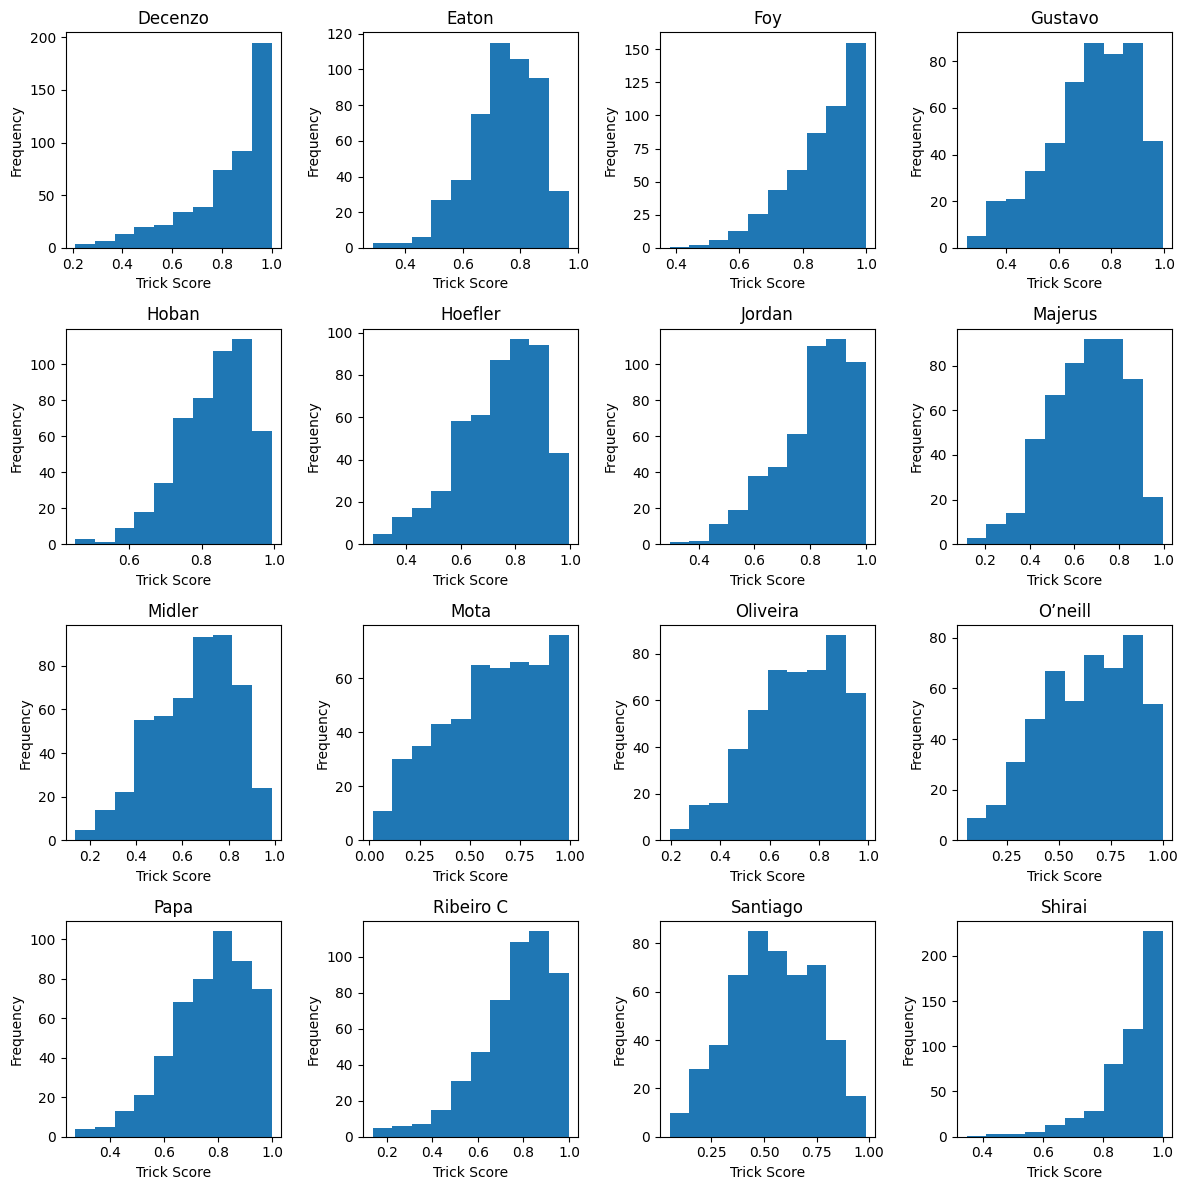

In [ ]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array to iterate over it
axes = axes.flatten()

for index, row in initial_bayesian_df_tricks.iterrows():
    samps = np.random.beta(row['alpha_metropolis'], row['betha_metropolis'], size=500)
    
    # Get the current subplot
    ax = axes[index]
    
    # Plot the histogram on the current subplot
    ax.hist(samps)
    ax.set_title(row['id'])
    ax.set_xlabel('Trick Score')
    ax.set_ylabel('Frequency')

# Hide any remaining empty subplots
for i in range(len(initial_bayesian_df_tricks), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

##### Second try at Metropolis algorithm:

In [ ]:
def metropolis_method_alt2(data, n_samples):
    
    alphas = np.zeros((n_samples))
    betas = np.zeros((n_samples))
    thetas = np.ones((n_samples))
    thetas = thetas * 0.5
    
    #init_guess = get_moment_estimators(data)
    init_guess = initial_guess_trick_with_zeroes

    alphas[0] = init_guess[0] 
    betas[0] = init_guess[1]

    for i in range(n_samples - 1):
        last_alpha = alphas[i]
        last_beta = betas[i]
        last_theta = thetas[i]
        
       # Att exponentiera ser till att alpha och beta är positivt, hade abs innan men det kan leda till alpha och beta med bias och det gick snabbare att konvergera
        proposal_alpha =  np.exp(np.log(last_alpha) + stats.norm.rvs( 0.5, size=1))[0]
        proposal_beta =   np.exp(np.log(last_beta) + stats.norm.rvs(0.5, size=1))[0]
        
        proposal_theta = abs(stats.uniform.rvs(0,1, size = 1))[0]

        
        # Note that the acceptance probability rho is calculated for the *pair* of
        # proposed samples.
        log_rho = log_posterior(proposal_alpha, proposal_beta, proposal_theta, data) - log_posterior(last_alpha, last_beta, last_theta, data)
        
        u = stats.uniform.rvs()
        
    
        if np.log(u) <= log_rho:
            alphas[i + 1] = proposal_alpha
            betas[i + 1] = proposal_beta
            thetas[i+1] = proposal_theta
        else:
            alphas[i + 1] = last_alpha
            betas[i + 1] = last_beta
            thetas[i +1] = last_theta
    
    return alphas, betas, thetas

In [ ]:
df_candidates = df[df['id'].isin(contestants)]

df_of_estimates = pd.DataFrame(contestants, columns=["id"])

def extract_trick_values(id, remove_zero):
    id_mask = (df["id"] == id)
    all_tricks = np.concatenate(df[id_mask][['trick 1', 'trick 2', 'trick 3', 'trick 4']].values)
    if remove_zero:

        non_zero_mask = all_tricks != 0
        return all_tricks[non_zero_mask]
    
    return all_tricks

df_of_estimates['theta_obs'] = np.nan

for id in df_candidates["id"]:
    id_mask = (id == df["id"])
    
    approx_succesfull_trick = np.mean(df[id_mask][["make 1", "make 2", "make 3", "make 4"]])
    
    df_of_estimates.loc[df_of_estimates['id'] == id, "theta_obs"] = approx_succesfull_trick

C:\Users\villi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\villi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\villi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.

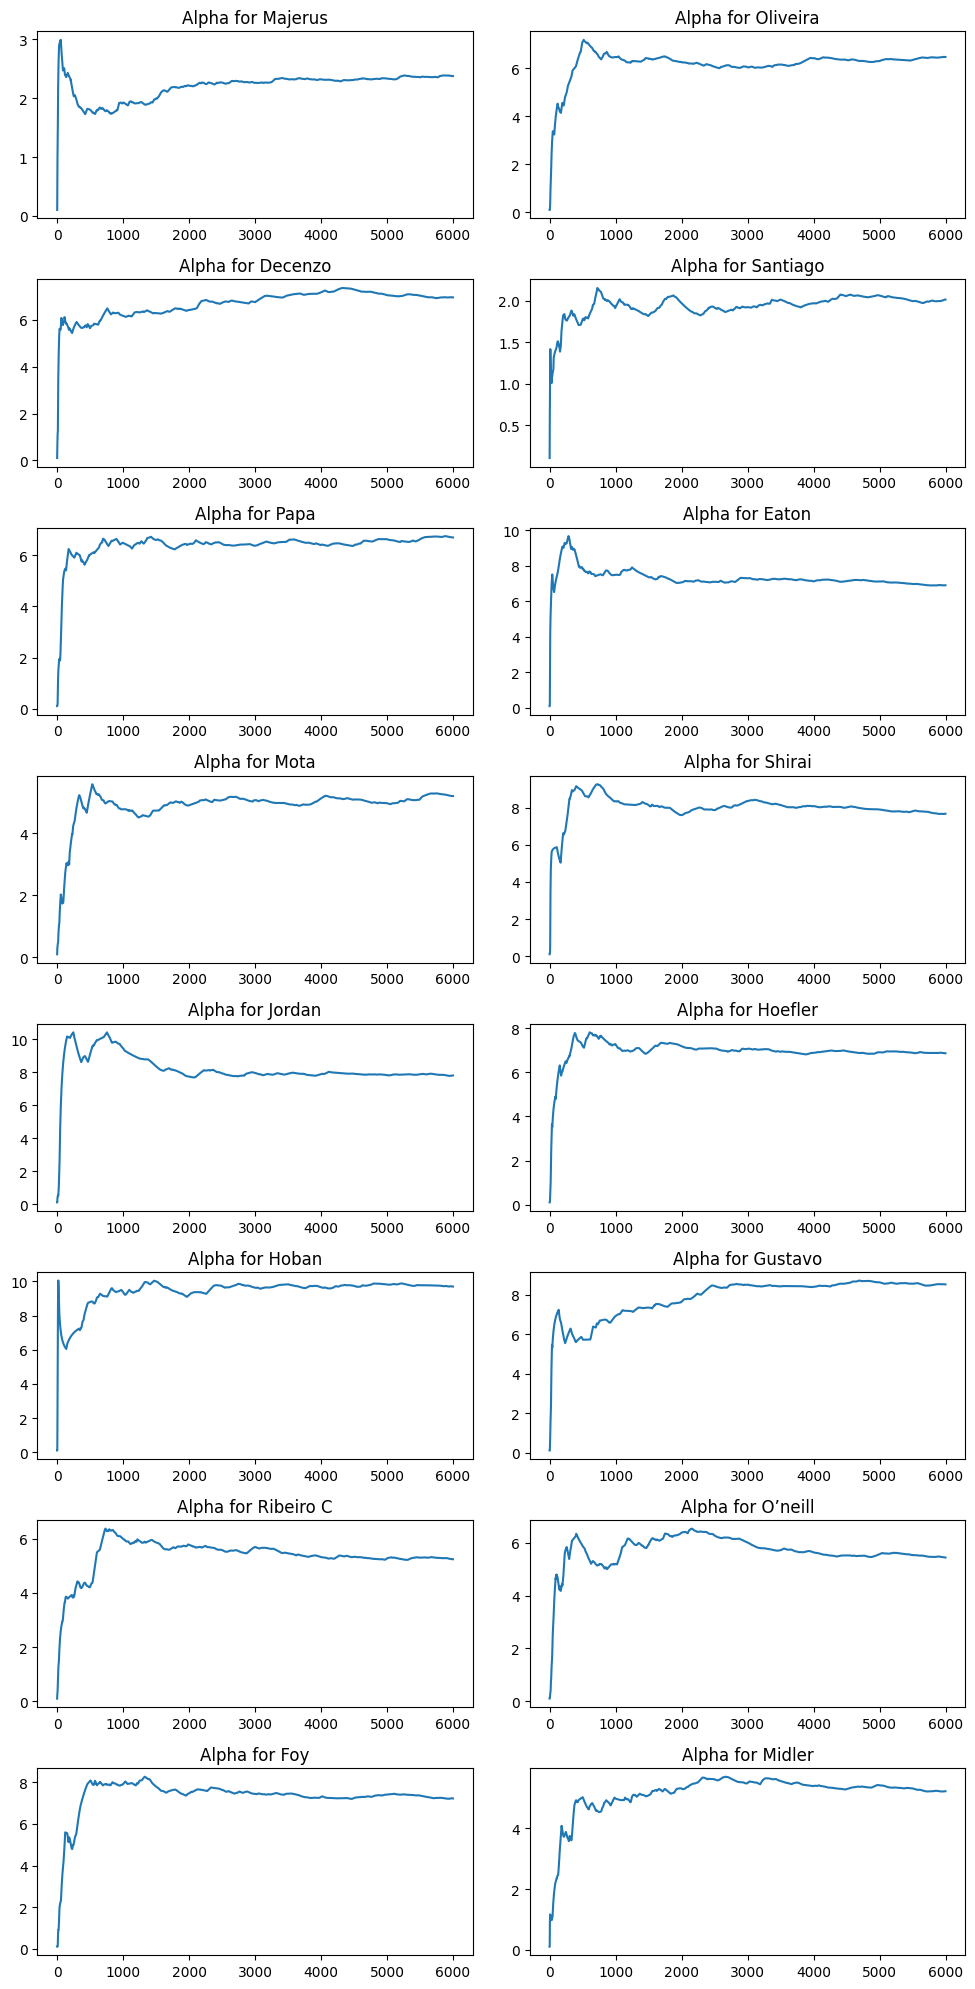

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(10, 20))
idx = 0
for i in range(8):
    for j in range(2):
        id = contestants[idx] 
        data = extract_trick_values(id, False)
        alphas, _, _=metropolis_method_alt2(data, 6000)
    
        axs[i, j].plot(np.cumsum(alphas) / np.arange(1, len(alphas) + 1))
        axs[i, j].set_title(f'Alpha for {id}')
        idx += 1


plt.tight_layout()
plt.show()

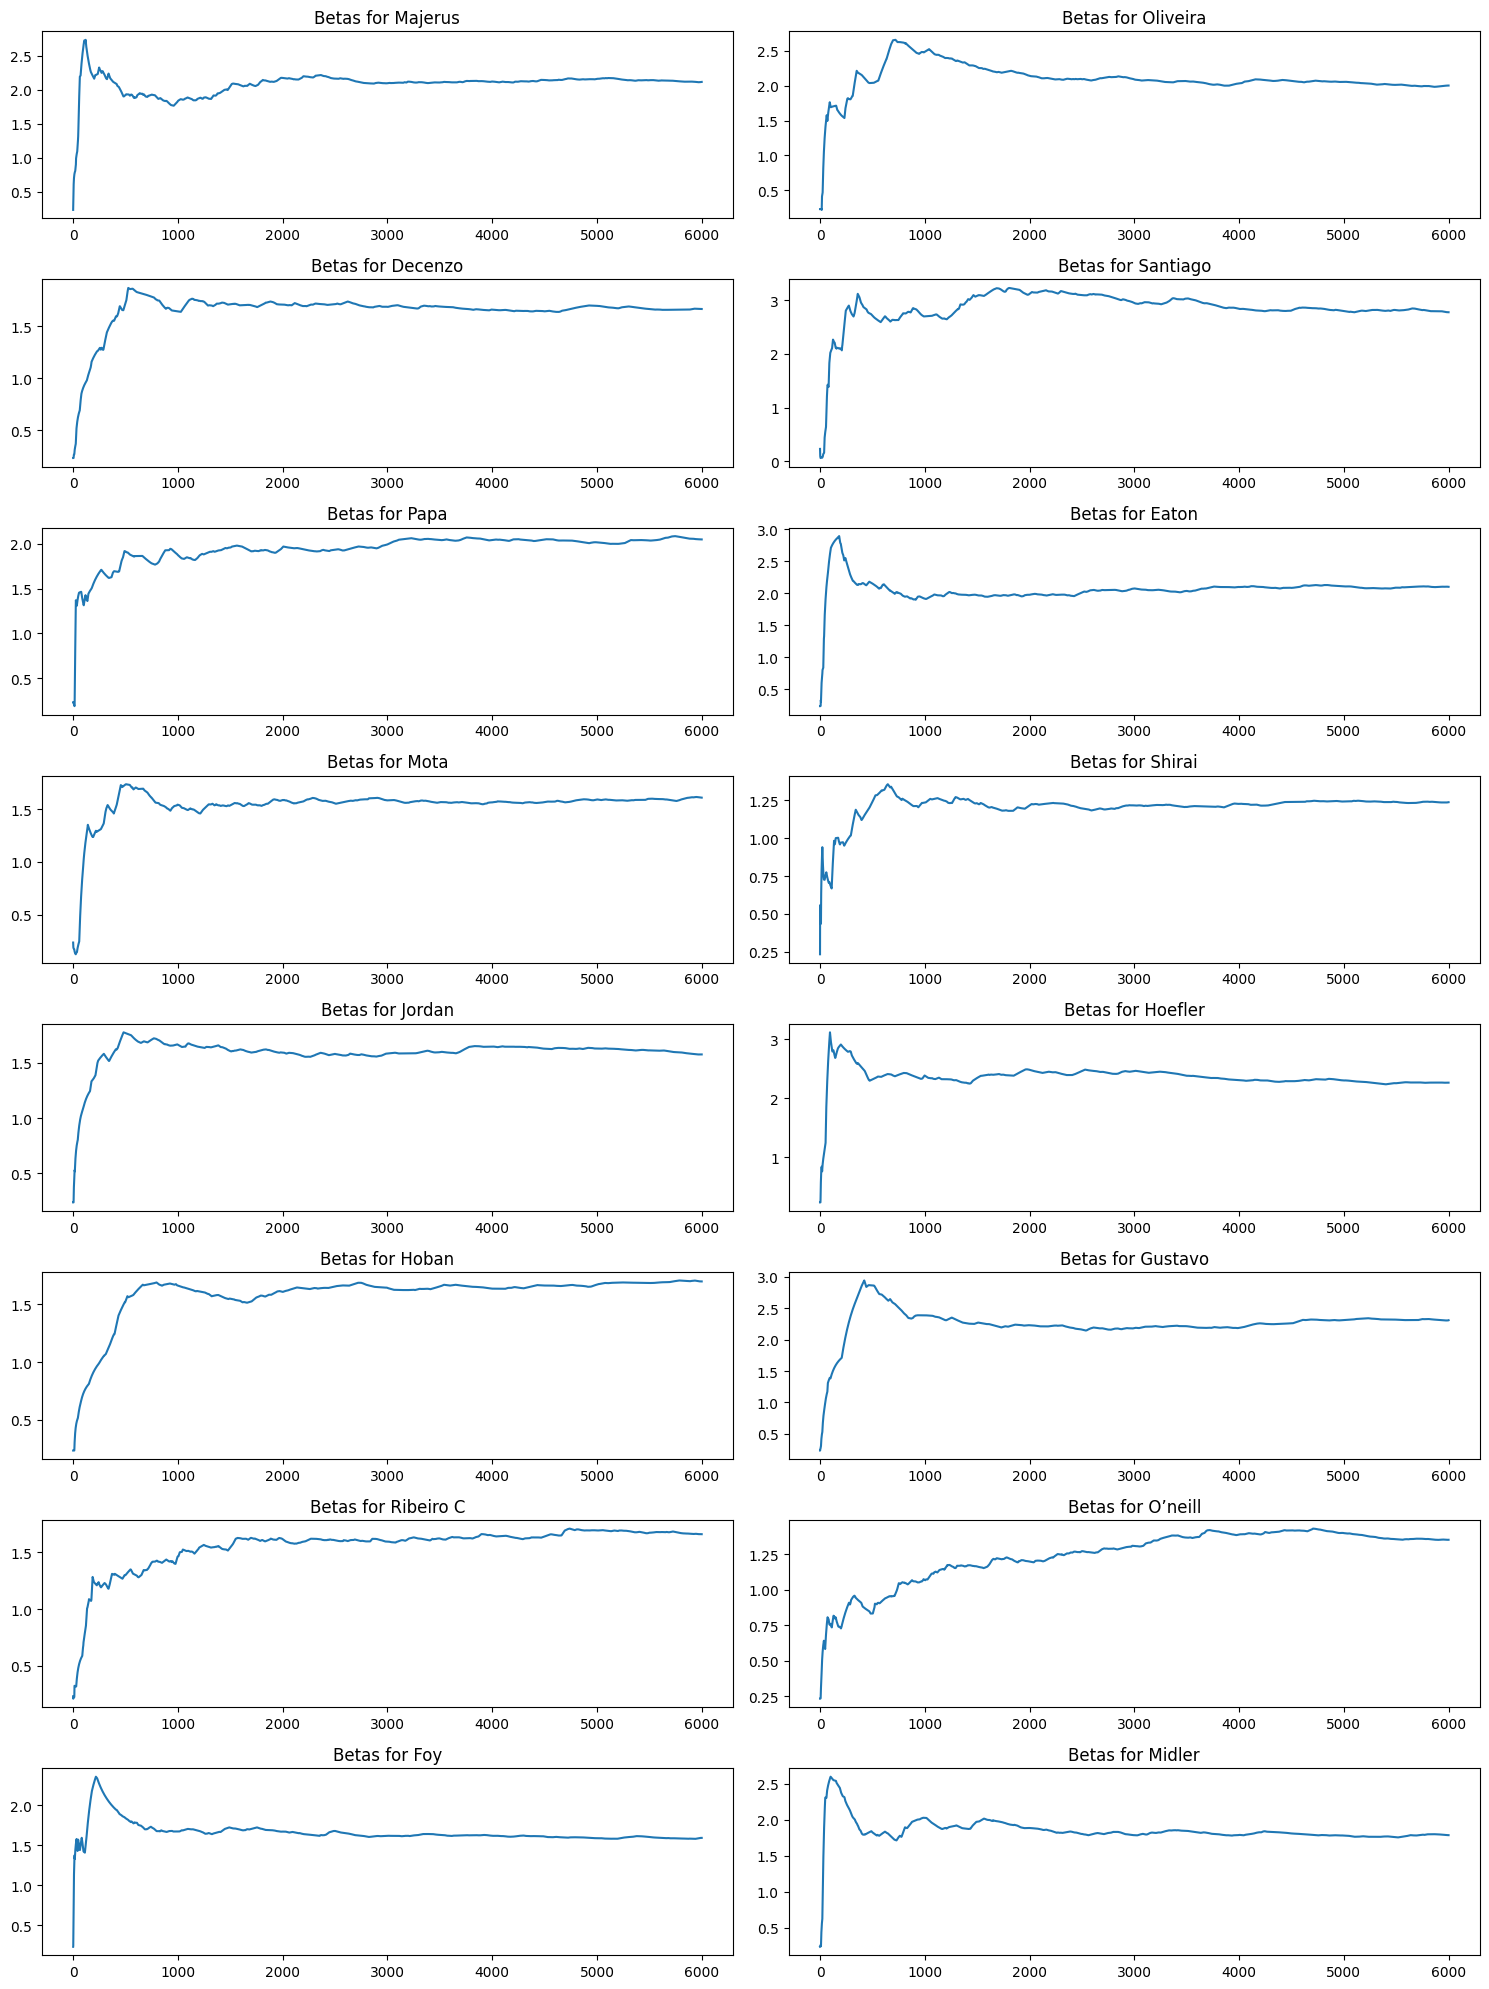

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(15, 20))
idx = 0
for i in range(8):
    for j in range(2):
        id = contestants[idx] 
        data = extract_trick_values(id, False)
        _, betas, _=metropolis_method_alt2(data, 6000)
    
        axs[i, j].plot(np.cumsum(betas) / np.arange(1, len(betas) + 1))
        axs[i, j].set_title(f'Betas for {id}')
        idx += 1


plt.tight_layout()
plt.show()

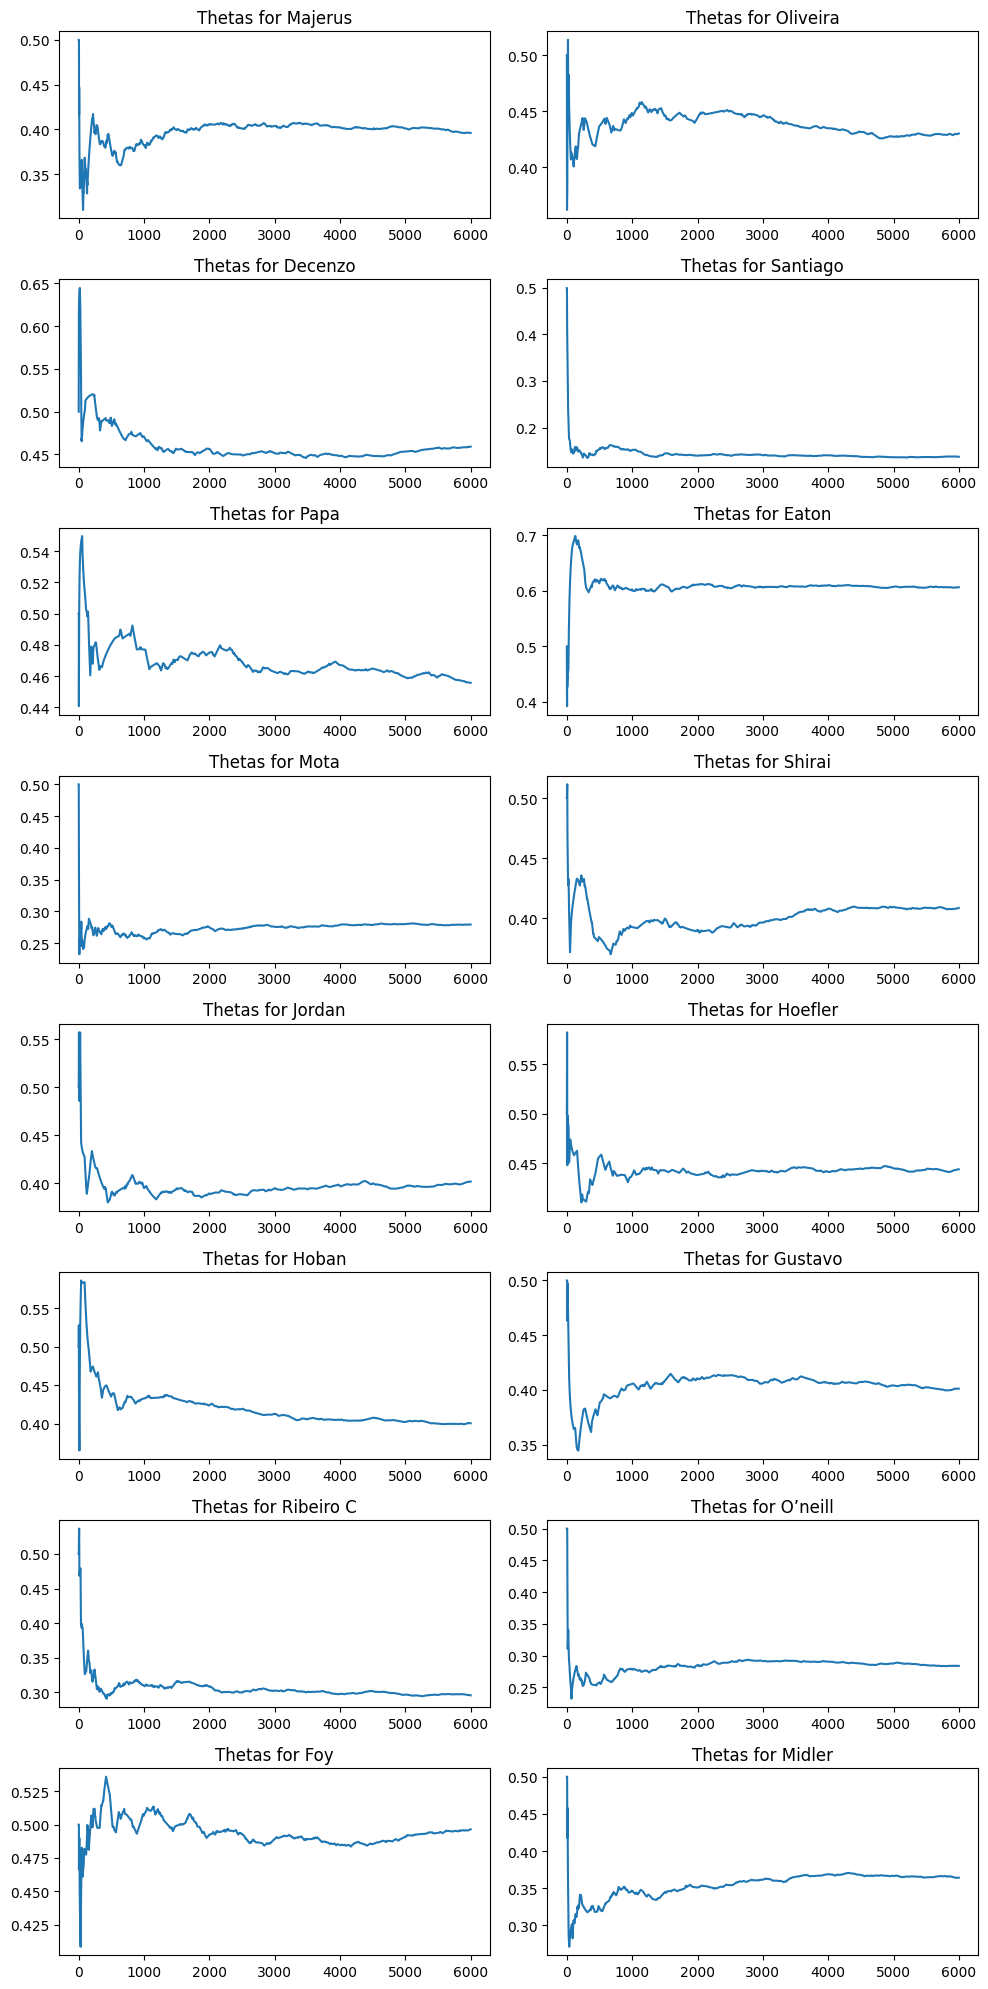

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(10, 20))
idx = 0

for i in range(8):
    for j in range(2):
        id = contestants[idx] 
        data = extract_trick_values(id, False)
        _, _, thetas=metropolis_method_alt2(data, 6000)
    
        axs[i, j].plot(np.cumsum(thetas) / np.arange(1, len(thetas) + 1))
        axs[i, j].set_title(f'Thetas for {id}')
        idx += 1


plt.tight_layout()
plt.show()

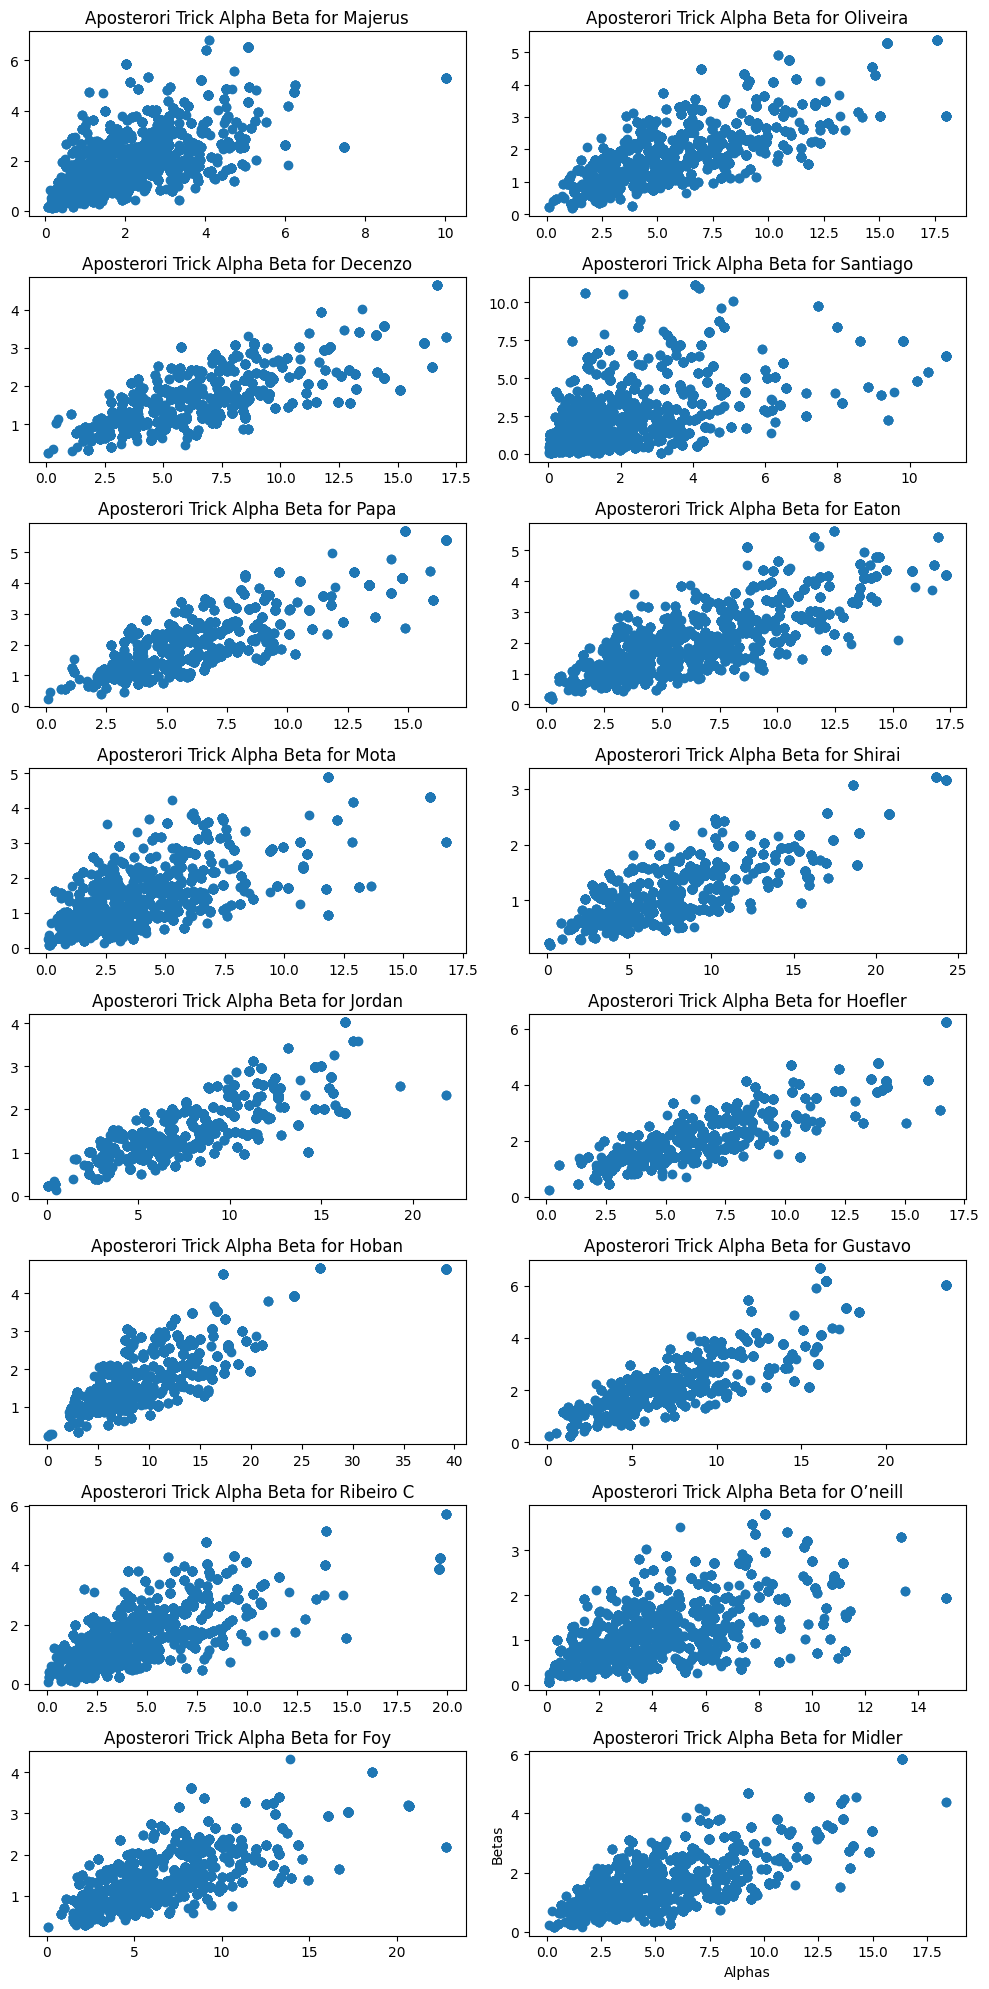

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(10, 20))

idx = 0

for i in range(8):
    for j in range(2):
        id = contestants[idx] 
        data = extract_trick_values(id, False)
        alphas, betas,_ =metropolis_method_alt2(data, 5000)
        axs[i, j].scatter(alphas, betas)
        plt.xlabel('Alphas')
        plt.ylabel('Betas')
        axs[i, j].set_title(f'Aposterori Trick Alpha Beta for {id}')
        idx += 1


plt.tight_layout()
plt.show()

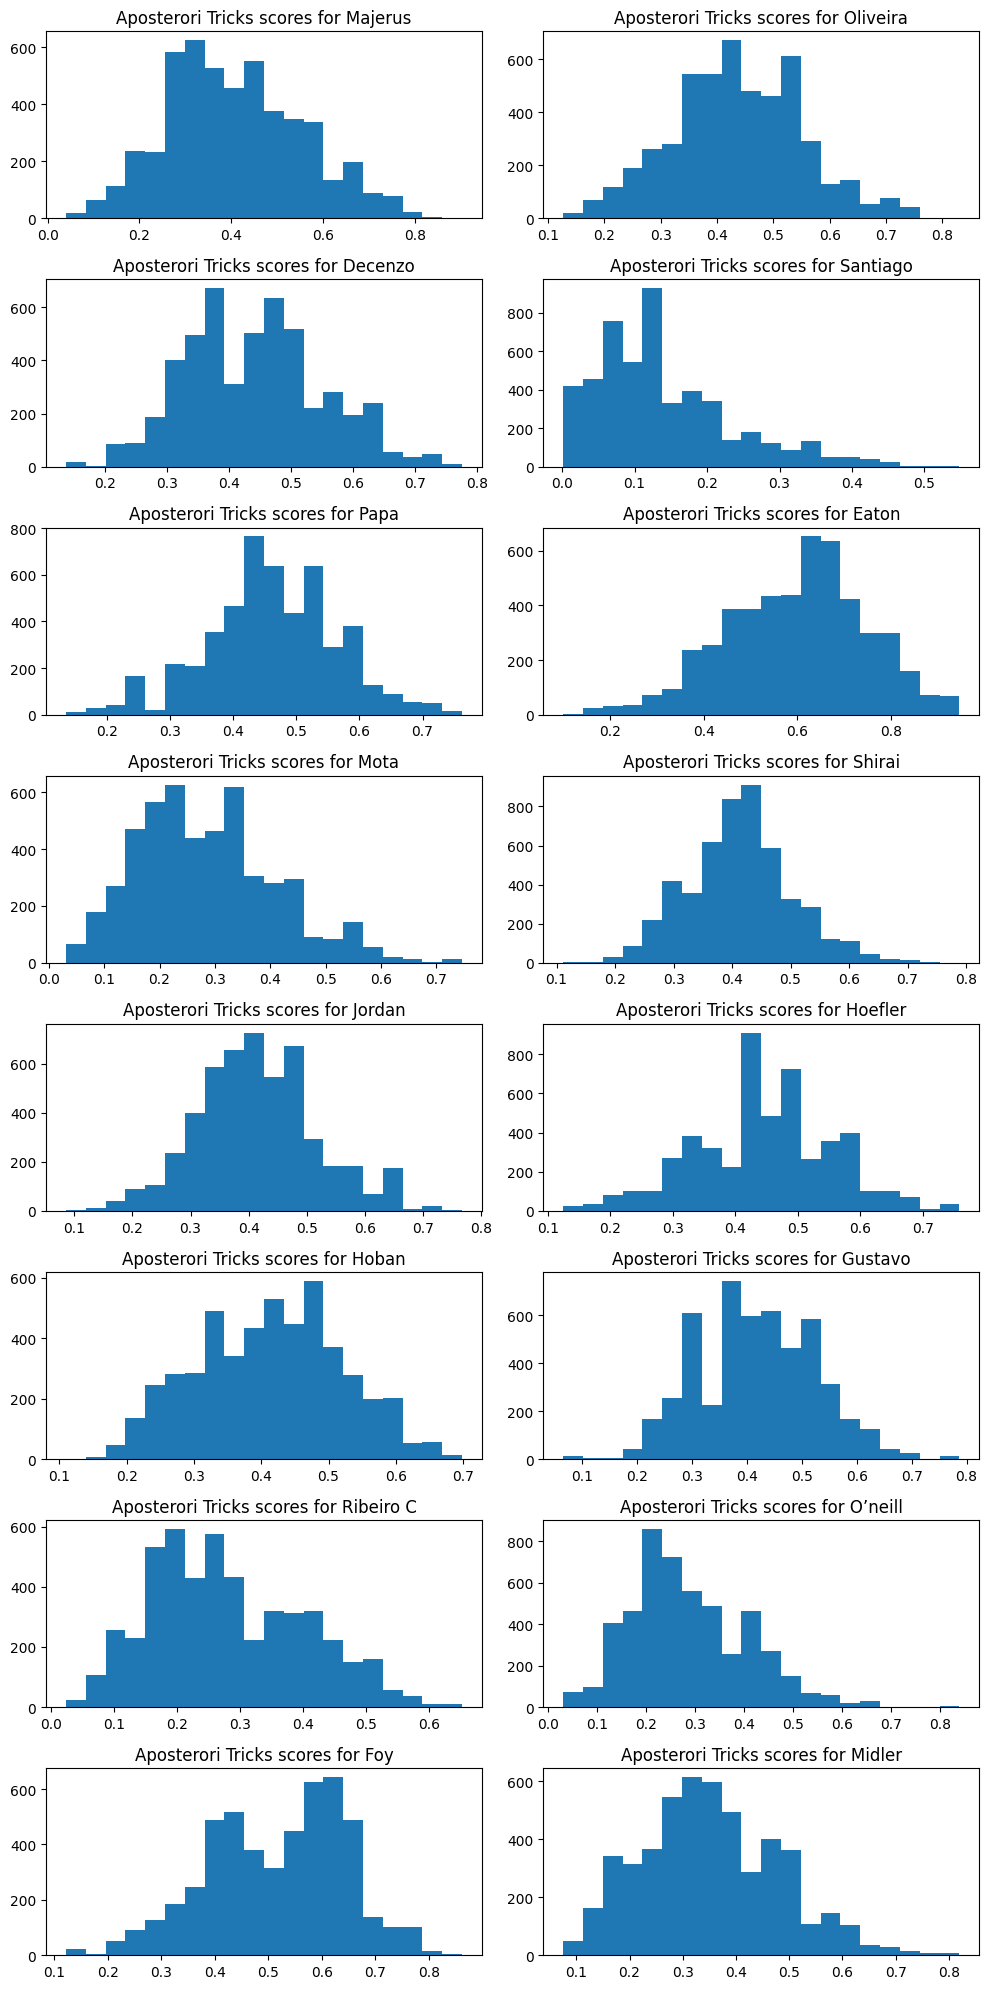

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(10, 20))

idx = 0

for i in range(8):
    for j in range(2):
        id = contestants[idx] 
        data = extract_trick_values(id, False)
        _,_,thetas=metropolis_method_alt2(data, 5000)
        axs[i, j].hist(thetas, bins= 20)
        axs[i, j].set_title(f'Aposterori Tricks scores for {id}')
        idx += 1


plt.tight_layout()
plt.show()

In [ ]:
df_of_estimates['alpha_bayes_X_mean'] = np.nan
df_of_estimates['beta_bayes_X_mean'] = np.nan
df_of_estimates['theta_bayes_mean'] = np.nan
df_of_estimates['alpha_bayes_X_s^2'] = np.nan
df_of_estimates['beta_bayes_X_s^2'] = np.nan
df_of_estimates['theta_bayes_s^2'] = np.nan


for id in contestants:
    
    data = extract_trick_values(id, False)
    alphas_est, betas_est, thetas_est = metropolis_method_alt2(data, 5000)
    df_of_estimates.loc[df_of_estimates['id'] == id, "alpha_bayes_X_mean"] = np.mean(alphas_est)
    df_of_estimates.loc[df_of_estimates['id'] == id, "beta_bayes_X_mean"] = np.mean(betas_est)
    df_of_estimates.loc[df_of_estimates['id'] == id, "theta_bayes_mean"] = np.mean(thetas_est)
    
    df_of_estimates.loc[df_of_estimates['id'] == id, "alpha_bayes_X_s^2"] = np.var(alphas_est, ddof= 1)
    df_of_estimates.loc[df_of_estimates['id'] == id, "beta_bayes_X_s^2"] = np.var(betas_est, ddof=1)
    df_of_estimates.loc[df_of_estimates['id'] == id, "theta_bayes_s^2"] = np.var(thetas_est, ddof=1)

df_of_estimates[['id', "alpha_bayes_X_mean", "beta_bayes_X_mean", "theta_bayes_mean", "alpha_bayes_X_s^2", "beta_bayes_X_s^2", "theta_bayes_s^2"]]
    

,id,alpha_bayes_X_mean,beta_bayes_X_mean,theta_bayes_mean,alpha_bayes_X_s^2,beta_bayes_X_s^2,theta_bayes_s^2
0,Majerus,2.486714,2.208221,0.401183,1.432636,1.256518,0.020252
1,Oliveira,6.157759,1.941321,0.438984,8.407156,0.780011,0.015874
2,Decenzo,6.182292,1.575137,0.450550,6.478981,0.370571,0.012640
3,Santiago,2.200642,2.699688,0.140615,2.008188,3.471935,0.007871
4,Papa,6.892947,2.305916,0.450498,8.042507,0.855585,0.012143
5,Eaton,6.046085,2.029750,0.595721,7.351344,0.743709,0.020772
6,Mota,4.661047,1.711206,0.284917,7.784164,0.887310,0.014455
7,Shirai,7.714678,1.161653,0.433691,10.378212,0.179672,0.009854
8,Jordan,8.227247,1.634593,0.405021,11.911198,0.358101,0.011725
9,Hoefler,7.155920,2.287073,0.455181,10.500210,0.930838,0.012143


## (c) 
- Propose a (joint) prior distribution for the parameters of your model $Y_i$ from task $2(c)$ and justify your choice. 

- You can assume that the model's parameters for skateboarder $i$ are independent of all other parameters including $\theta_i$, $\alpha_i$, and $\beta_i$. 

- Generate 5000 samples from the posterior distribution (make sure to save these samples!) and create a scatter plot of the results. 

- What is the sample mean and sample variance for each of your parameters based on your outcomes?

In [ ]:
from scipy.special import loggamma

def log_prior_Y(alpha, beta, precision, lambda_hyper):
    
    theta_hyper = lambda_hyper*precision
    
    return theta_hyper * np.log(lambda_hyper) - loggamma(theta_hyper) + (theta_hyper - 1) * np.log(alpha + beta + 1) - lambda_hyper * (alpha + beta + 1) - np.log(alpha + beta)

In [ ]:
def log_posterior_Y(alpha, beta, data):
    
    precision = 5
    lambda_hyper = 0.5

    log_p = log_prior(alpha, beta, precision, lambda_hyper)
    
    for z_i in data:
        log_p +=  loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha-1) * np.log(z_i) + (beta-1) * np.log(1-z_i)
            
    return log_p 

In [ ]:
def metropolis_method_Y(data, n_samples):
    
    alphas = np.zeros((n_samples))
    betas = np.zeros((n_samples))
    
    init_guess = initial_guess_trick_with_zeroes

    alphas[0] = init_guess[0] 
    betas[0] = init_guess[1]

    for i in range(n_samples - 1):
        last_alpha = alphas[i]
        last_beta = betas[i]
    
        
       # Att exponentiera ser till att alpha och beta är positivt, hade abs innan men det kan leda till alpha och beta med bias och det gick snabbare att konvergera
        proposal_alpha =  np.exp(np.log(last_alpha) + stats.norm.rvs( 0.5, size=1))[0]
        proposal_beta =   np.exp(np.log(last_beta) + stats.norm.rvs(0.5, size=1))[0] 

        # Note that the acceptance probability rho is calculated for the *pair* of
        # proposed samples.
        log_rho = log_posterior_Y(proposal_alpha, proposal_beta, data) - log_posterior_Y(last_alpha, last_beta, data)
        
        u = stats.uniform.rvs()
        
    
        if np.log(u) <= log_rho:
            alphas[i + 1] = proposal_alpha
            betas[i + 1] = proposal_beta
            
        else:
            alphas[i + 1] = last_alpha
            betas[i + 1] = last_beta
           
    
    return alphas, betas

In [ ]:
def extract_run_values(id):
    id_mask = (df["id"] == id)
    all_runs = np.concatenate(df[id_mask][['run 1', 'run 2']].values)
    
    return all_runs

for id in contestants:
    data = extract_run_values(id)
    
    
    estimates = get_moment_estimators(data)
    
    df_of_estimates.loc[df_of_estimates['id'] == id, "moment_alpha_Y"] = estimates[0] #alpha
    df_of_estimates.loc[df_of_estimates['id'] == id, "moment_beta_Y"] = estimates[1] #Beta

df_of_estimates[['id', 'moment_alpha_Y', 'moment_beta_Y']]

,id,moment_alpha_Y,moment_beta_Y
0,Majerus,1.212651,1.709400
1,Oliveira,4.396292,3.294015
2,Decenzo,3.569568,2.429706
3,Santiago,2.170197,3.515908
4,Papa,1.829142,1.748642
5,Eaton,77.495591,27.583176
6,Mota,3.301811,3.723318
7,Shirai,1.594273,0.956564
8,Jordan,3.172789,1.080279
9,Hoefler,1.454558,0.800570


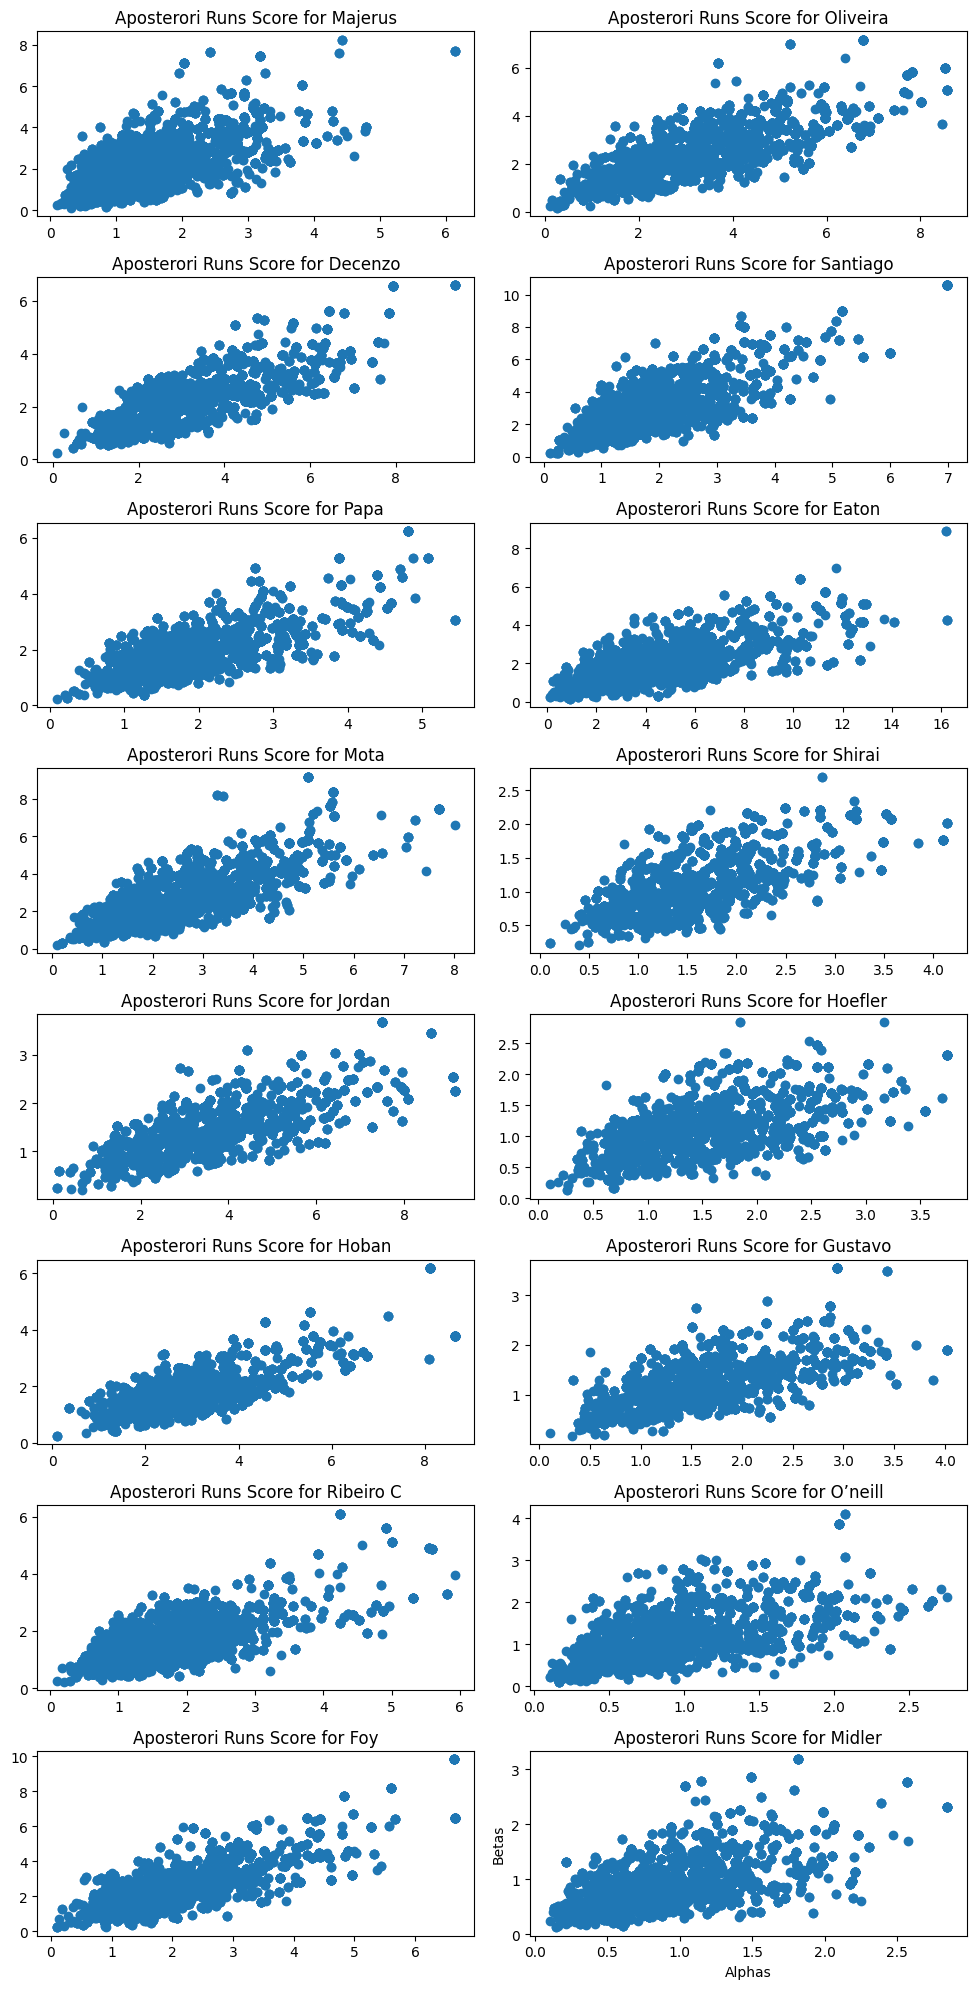

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 2, figsize=(10, 20))

idx = 0

for i in range(8):
    for j in range(2):
        id = contestants[idx] 
        data = extract_run_values(id)
        alphas, betas =metropolis_method_Y(data, 5000)
        axs[i, j].scatter(alphas, betas)
        plt.xlabel('Alphas')
        plt.ylabel('Betas')
        axs[i, j].set_title(f'Aposterori Runs Score for {id}')
        idx += 1

plt.tight_layout()
plt.show()


In [ ]:
df_of_estimates['alpha_bayes_Y_mean'] = np.nan
df_of_estimates['beta_bayes_Y_mean'] = np.nan
df_of_estimates['alpha_bayes_Y_s^2'] = np.nan
df_of_estimates['beta_bayes_Y_s^2'] = np.nan


for id in contestants:
    
    data = extract_run_values(id)
    alphas_est, betas_est = metropolis_method_Y(data, 5000)
    df_of_estimates.loc[df_of_estimates['id'] == id, "alpha_bayes_Y_mean"] = np.mean(alphas_est)
    df_of_estimates.loc[df_of_estimates['id'] == id, "beta_bayes_Y_mean"] = np.mean(betas_est)
    df_of_estimates.loc[df_of_estimates['id'] == id, "alpha_bayes_X_s^2"] = np.var(alphas_est, ddof= 1)
    df_of_estimates.loc[df_of_estimates['id'] == id, "beta_bayes_X_s^2"] = np.var(betas_est, ddof=1)

df_of_estimates[['id', "alpha_bayes_Y_mean",  "beta_bayes_Y_mean", "alpha_bayes_X_s^2", "beta_bayes_X_s^2"]]

,id,alpha_bayes_Y_mean,beta_bayes_Y_mean,alpha_bayes_X_s^2,beta_bayes_X_s^2
0,Majerus,1.617278,2.360390,0.636266,1.518753
1,Oliveira,3.482146,2.698732,2.434027,1.370366
2,Decenzo,3.235073,2.236616,1.732704,0.832756
3,Santiago,2.153824,3.410097,0.969330,2.477708
4,Papa,2.189584,2.154217,0.823385,0.784621
5,Eaton,5.471693,2.318703,7.958623,1.468669
6,Mota,2.811327,3.032783,1.511518,1.661642
7,Shirai,1.638955,1.184930,0.381357,0.201714
8,Jordan,3.928438,1.513035,2.161044,0.289140
9,Hoefler,1.474328,1.083481,0.427927,0.221573


## (d) 
Use your Bayesian model for $[X_i, Y_i]^T$ to simulate 5000 LCQs by drawing samples from the appropriate posterior predictive distributions. 

- What is the mode of your outcomes $W_1, \ldots, W_{5000}$? 

- How many of the real winners are predicted? 

- What is the estimated probability of the real winners based on your samples? 

- And by the mode?

In [ ]:
df_of_estimates[['id',"theta_bayes_mean", "alpha_bayes_X_mean", "beta_bayes_X_mean",  "alpha_bayes_Y_mean",  "beta_bayes_Y_mean"]]

,id,theta_bayes_mean,alpha_bayes_X_mean,beta_bayes_X_mean,alpha_bayes_Y_mean,beta_bayes_Y_mean
0,Majerus,0.401183,2.486714,2.208221,1.617278,2.360390
1,Oliveira,0.438984,6.157759,1.941321,3.482146,2.698732
2,Decenzo,0.450550,6.182292,1.575137,3.235073,2.236616
3,Santiago,0.140615,2.200642,2.699688,2.153824,3.410097
4,Papa,0.450498,6.892947,2.305916,2.189584,2.154217
5,Eaton,0.595721,6.046085,2.029750,5.471693,2.318703
6,Mota,0.284917,4.661047,1.711206,2.811327,3.032783
7,Shirai,0.433691,7.714678,1.161653,1.638955,1.184930
8,Jordan,0.405021,8.227247,1.634593,3.928438,1.513035
9,Hoefler,0.455181,7.155920,2.287073,1.474328,1.083481


In [ ]:
def simulate_lcq_bayes(df_of_estimates):
    new_lcq_df_bayes = pd.DataFrame(columns=["id", "run 1", "run 2", "trick 1", "trick 2", "trick 3", "trick 4"])
    
    for index, row in df_of_estimates.iterrows():
        
        theta_average=row['theta_bayes_mean']
        alpha_trick=row['alpha_bayes_X_mean']
        beta_trick=row['beta_bayes_X_mean']    
        alpha_run=row['alpha_bayes_Y_mean']
        beta_run=row['beta_bayes_Y_mean']
        
        new_lcq_df_bayes.at[index, "id"]=row['id']
        
        for _ in range(4):
            if successful_trick(theta_average):
                trick=trick_score(alpha_trick, beta_trick)
            else:
                trick=0
            new_lcq_df_bayes.at[index, f"trick {_+1}"] = round(trick,1)
        
        for _ in range(2):
            run=run_score(alpha_run, beta_run)
            new_lcq_df_bayes.at[index, f"run {_+1}"] = round(run,1)
        
        total_score_value=total_score(new_lcq_df_bayes.loc[index, ['trick 1', 'trick 2', 'trick 3', 'trick 4']], new_lcq_df_bayes.loc[index, ['run 1', 'run 2']]) 
        new_lcq_df_bayes.at[index, "total score"]=round(total_score_value,1)
    
    return new_lcq_df_bayes

In [ ]:
win_counts_bayes = {}

for _ in range(5000):
    top_four_df=find_top_four_skateboarders(simulate_lcq_bayes(df_of_estimates))
    winner_id = top_four_df.iloc[0]['id']
    win_counts_bayes[winner_id] = win_counts_bayes.get(winner_id, 0) + 1
    
df_win_counts_bayes = pd.DataFrame(list(win_counts_bayes.items()), columns=['id', 'win_count'])
df_ranked_bayes = df_win_counts_bayes.sort_values(by='win_count', ascending=False)

df_ranked_bayes

,id,win_count
5,Shirai,1054
3,Jordan,783
6,Eaton,664
1,Decenzo,470
7,Hoban,463
9,Hoefler,314
0,Oliveira,278
2,Gustavo,258
4,Papa,191
11,Midler,183


The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 

## (e) 
In the model in task $3(\mathrm{d})$, we assumed that the parameters $\Upsilon_i$ for $Y_i$ and the parameters $\Theta_i = [\Theta_i, A_i, B_i]^T$ for $X_i$ are independent given the data. 

- Why?

Answer

At the same time, we did not assume that $\Theta_i \perp A_i, B_i$ are independent given the data. 

1. Let $X_i^{(1)}, X_i^{(2)}, X_i^{(3)}, X_i^{(4)}$ denote skateboarder $i$'s four trick scores.
2. Let $Y_i^{(1)}, Y_i^{(2)}$ denote skateboarder $i$'s two run scores.
3. Let $O_i$ denote their total score. 

- Draw a directed acyclic graph with as few edges as possible so that the joint distribution of $O_i, X_i^{(1)}, X_i^{(2)}, X_i^{(3)}, X_i^{(4)}, Y_i^{(1)}, Y_i^{(2)}, \Theta_i, A_i, B_i$ and $\Upsilon$ is Markov with respect to it. 

Answer


- Based on your graph, can you conclude that the marginal posterior distribution for $\Theta_i, A_i$, and $B_i$ factorizes as:
$$
f_{\theta_i, \alpha_i, \beta_i | \boldsymbol{X}_i}(\theta_i, \alpha_i, \beta_i | \boldsymbol{x}_i) = f_{\theta_i | \boldsymbol{X}_i}(\theta_i | \boldsymbol{x}_i) f_{\alpha_i, \beta_i | \boldsymbol{X}_i}(\alpha_i, \beta_i | \boldsymbol{x}_i) ?
$$

Answer


Consider your parameters $\Upsilon_i$ for $Y_i$ and the parameters $\Theta_i$ for $X_i$. 

- According to your graph, is the following assumption reasonable?

$$
\Upsilon_i \perp \Theta_i | X_i^{(1)}, X_i^{(2)}, X_i^{(3)}, X_i^{(4)}, Y_i^{(1)}, Y_i^{(2)}
$$

Answer

- Can we assume the independence relation $\Upsilon_i \perp \Theta_i | O_i$ if only the data $o_i$ is given instead?

In [ ]:
#Code

Answer

# 4. A Bayesian model with a hierarchy
To account for possible variations in skateboarders' performances between different competitions, we can build a model that uses a hierarchy. As we saw in the lectures, we can build a Bayesian hierarchy for $V_i \sim \operatorname{Ber}(\theta_i)$ if we group outcomes $v_i$ according to the different competitions. For simplicity, we use our frequentist point estimates for the parameters $\alpha_i, \beta_i$ and the parameters for $Y_i$ from task 2.

## (a) 
Assume that $\Theta_i \mid A_i=\alpha_i, B_i=\beta_i \sim \operatorname{Beta}(\alpha_i, \beta_i)$ and choose a suitable simultaneous prior distribution for $\left[\Theta_i, A_i, B_i\right]^T$. 

- Justify your choice.

Answer

## (b) 

Generate 5000 random outcomes from the simultaneous posterior distribution
$$
f_{A_i, B_i \mid \boldsymbol{X}_i}(a_i, b_i \mid \boldsymbol{x}_i) .
$$

In [ ]:
#Code

Use your simulations to generate 5000 random outcomes from the marginal posterior distribution $\Theta_i \mid \boldsymbol{X}_i=\boldsymbol{x}_i$.

In [ ]:
#Code

Plot your outcomes for the following posterior distributions:
$$
f_{\theta_i \mid \boldsymbol{X}_i}(\theta_i \mid \boldsymbol{x}_i) \quad \text{and} \quad f_{A_i, B_i \mid \boldsymbol{X}_i}(a_i, b_i \mid \boldsymbol{x}_i) ,
$$

In [ ]:
#Code

Provide estimates for the posterior expected value and posterior variance for each of the parameters. 

- How do these variances for $\theta_i$ compare to the variances for $\theta_i$ computed for the model in Task 3?

Answer

## (c) 
Using your $5000$ samples from part (b), simulate 5000 LCQ competition winners and calculate the mode of the results. 

- What are the respective estimated probabilities for the actual winners and your mode value?

In [ ]:
# Code

Answer

# 5. Discussion 
It is always important to reflect on our model assumptions when conducting statistical inference. Specifically, it is important to assess how the models can be improved.

## (a) 

- How do the results (the skateboarders in the typical values) from the different models compare? 

- Which skateboarders are correctly predicted and which are not? 

- Provide some possible explanations for the differences between the predictions of the different models. 

- Which model do you prefer and why?

Answer

## (b) 

- How do your estimates for $\theta_i$ in Assignment 1 compare to your estimated expected values and variances for $\theta_i$ in Assignments 3 and 4? 

- What is the expected score for a trick for each skateboarder given that the trick has been successfully landed? What is the expected run score? 

- Considering the skateboarders who are predicted to win according to the different models, do these statistics provide any insights into successful strategies for winning? 

- For example, does it work to focus on a good run score over good trick scores? 

- Are there instances where this strategy works? 

- Is it better to have higher trick scores with high variance or slightly worse trick scores with less variance? etc.

Answer

## (c) 

- Estimate the expected value and standard deviation for each skateboarder's total score for the models in Assignments 3 and 4. 

- Do these statistics support your predictions? 

- According to these statistics, what needs to occur for the outcome to be the actual winners?

Answer

## (d) 

- In all the models, we assumed that the skateboarder's performances are independent. For example, we assumed that all $V_i$ are independent. 

- Does this seem like a reasonable assumption? Justify your answer.

Answer

## (e) 

- In all the models, we ignored the order in which the skateboarders took turns. Does this seem like a reasonable thing to do? 

- Why or why not?

Answer